# Digital Biomarkers of Major Depressive Disorder
## Adams Clinical Dataset

August 8th 2020<br>
by Vidya Koesmahargyo

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import pingouin as pg
import warnings
from IPython.display import display, HTML
warnings.filterwarnings('ignore')

In [2]:
pd.set_option("display.max_columns",500)
pd.set_option("display.max_rows",500)

### Loading Data

In [3]:
# Loading the .csv file for the dataframe
df = pd.read_csv('AdamsClinical_Data.csv', index_col = [0,1])

# Turning the gender measure into a binary variable
df['Gender'] = df['Gender'].replace({'Male': 0, 'Female': 1})

# Removing all PHQ9 columns since that data is not great
df = df.loc[:,~df.columns.str.contains('PHQ')]

# Selecting first five weeks only
df = df.loc[[1,2,3,4,5]]

#creating duplicate MADRS column to normalize
df['MADRS_norm'] = df['MADRS']

### Listing all biomarkers

In [4]:
def get_biomarkers(df):
    not_biomarkers = ['SUBJID','AIQSDAT','MADRS', 'SITEID','STUDYID','age','sex','Day','Age','Gender','AIQSTIM','AIQTZ','AIQSLAN','AIQSLAN','aicure_master_event','QNNUUID']
    biomarkers = df.columns.values
    biomarker_list = sorted(list(set(biomarkers)-set(not_biomarkers)))
    return biomarker_list

In [5]:
biomarkers = get_biomarkers(df)
biomarkers = [ x for x in biomarkers if "mfcc" not in x ]
biomarkers = [ x for x in biomarkers if "AU" not in x ]
biomarkers = [ x for x in biomarkers if "LMK" not in x ]
biomarkers = [ x for x in biomarkers if "skew" not in x ]
biomarkers = [ x for x in biomarkers if "grad" not in x ]
biomarkers = [ x for x in biomarkers if "kurt" not in x ]
biomarkers = [ x for x in biomarkers if "AsymMask" not in x ]

### Combining biomarkers during freespeech/VST 

In [12]:
new_biomarkers = []
biomarkers = [x for x in biomarkers if 'img' in x]

for b in biomarkers:
    
    idx = b.index('img')
    name = b[:(idx)-4]
    
    neg = name+'_negimg'
    pos = name+'_posimg'
    neu = name+'_neuimg'
    
    df[name+'_allimg'] = df.apply(lambda x: np.array(x[pos]+ x[neg]+x[neu]).mean(),axis = 1)

    if name not in new_biomarkers:
        new_biomarkers.append(name)
        

### Normalizing all biomarkers and MADRS score

In [14]:
for dbm in biomarkers + new_biomarkers + ['MADRS_norm']:
    df[dbm] = (df[dbm] - df[dbm].min()) / (df[dbm].max() - df[dbm].min()) # Normalized 0-1
    # df[dbm] = (df[dbm] - df[dbm].mean()) / df[dbm].std(ddof=0) # Z-scored

## DBM / MADRS Across Timepoints

In [15]:
def comb(var, dft1, dft2, dft3):
    
    dftx = pd.DataFrame()
    dftx['T1'] = dft1[var]
    dftx['T2'] = dft2[var]
    dftx['T3'] = dft3[var]
    dftx = dftx.dropna()
    n = len(dftx)
    
    return n, dftx

In [16]:
dft1 = df.query('Week == 1')
dft1 = dft1.reset_index(level = 'Week', drop = True)
dft2 = df.query('Week == 2').append(df.query('Week == 3'))
dft2 = dft2.groupby('SUBJID').mean()
dft3 = df.query('Week == 4').append(df.query('Week == 5'))
dft3 = dft3.groupby('SUBJID').mean()

In [17]:
n, dftx = comb('MADRS', dft1, dft2, dft3)
dftx['pct_diff'] = (1 - (dftx['T3']/dftx['T1'])) * 100
dftx_resp = dftx[dftx['pct_diff'] > 30]
dftx_nrsp = dftx[dftx['pct_diff'] < 20]
both = dftx.index
resp = dftx_resp.index
nrsp = dftx_nrsp.index

In [18]:
# plot function for MADRS
def plot_madrs(var, dft1,dft2,dft3, condition, title=None):
    
    n, dftx = comb(var, dft1, dft2, dft3)
    
    dftx = dftx[dftx.index.isin(condition)]
    n = len(dftx)
    
#     print(var+', n = '+str(n))
    
    avgs = dftx.mean()
    errs = dftx.sem()
    
    fig = plt.figure(1, figsize=(8, 6))

    plt.errorbar([1, 3, 5], avgs, errs, linestyle = '-', marker = '^',c='mediumseagreen',alpha= 0.7,label = 'MADRS')
    plt.axhline(y=33,ls = '--', alpha=0.5, c = 'lightcoral')
    plt.axhline(y=19,ls='--',alpha=0.5, c ='dodgerblue')
    plt.ylabel(var + '\n',fontsize= 12)
    plt.xlabel('\nWeek',fontsize=12)
    plt.yticks(np.arange(20,40,2.5))
    plt.xticks([1, 2, 3, 4, 5])
    plt.grid(axis='y')
#     plt.title('Change in ' + var + ', n = ' + str(n) + '\n')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.title('MADRS Total Score\n',fontsize = 14)
    plt.savefig(title+'.png')
    plt.show()

In [19]:
#plotting function for variables from VST or with pos,neg,neu img tag
def plot_paper_img(madrs, var, dft1, dft2, dft3, condition, title=None):
    
    n, dftx = comb(madrs, dft1, dft2, dft3)
    
    dftx = dftx[dftx.index.isin(condition)]
    n = len(dftx)
        
    avgs = dftx.mean()
    errs = dftx.sem()
        
    mean_var_pos = comb(var+'_posimg', dft1, dft2, dft3)[1].mean()
    err_var_pos = comb(var+'_posimg', dft1, dft2, dft3)[1].sem()
    mean_var_neg = comb(var+'_negimg', dft1, dft2, dft3)[1].mean()
    err_var_neg = comb(var+'_negimg', dft1, dft2, dft3)[1].sem()
    mean_var_neu = comb(var+'_neuimg', dft1, dft2, dft3)[1].mean()
    err_var_neu = comb(var+'_neuimg', dft1, dft2, dft3)[1].sem()

    n,temp = comb(var+'_neuimg', dft1, dft2, dft3)
    n = len(temp)
    
    fig = plt.figure(1, figsize=(8, 6))

    plt.errorbar([1, 3, 5], mean_var_neg, err_var_neg, linestyle = '-', marker = '^',c='tab:red',alpha= 0.7,label='Negative')
    plt.errorbar([1, 3, 5], mean_var_neu, err_var_neu, linestyle = '-', marker = '^',c='tab:blue',alpha= 0.7,label='Neutral')
    plt.errorbar([1, 3, 5], mean_var_pos, err_var_pos, linestyle = '-', marker = '^',c='tab:green',alpha= 0.7,label='Positive')

    plt.errorbar([1, 3, 5], avgs, errs, linestyle = '-', marker = '^',c='tab:purple',alpha= 0.7,label='MADRS')

    plt.xlabel('\nWeek',fontsize=12)
    plt.yticks(np.arange(0,0.9,0.1))
    plt.xticks([1, 2, 3, 4, 5])
    plt.grid(axis='y')
    
    plt.title( title + '\n')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.legend()
    plt.savefig(title+'.png')
    
    plt.show()
    

In [20]:
#plot function for DBM variable vs. MADRS
def plot_paper_comb(madrs, var, dft1, dft2, dft3, condition, title=None):
    
    n, dftx = comb(madrs, dft1, dft2, dft3)
    
    dftx = dftx[dftx.index.isin(condition)]
    n = len(dftx)
        
    avgs = dftx.mean()
    errs = dftx.sem()
        
    mean_var = comb(var, dft1, dft2, dft3)[1].mean()
    err_var = comb(var, dft1, dft2, dft3)[1].sem()

    n,temp = comb(var, dft1, dft2, dft3)
    n = len(temp)
    
    fig = plt.figure(1, figsize=(8, 6))

    plt.errorbar([1, 3, 5], mean_var, err_var, linestyle = '-', marker = '^',c='tab:blue',alpha= 0.7,label=title)

    plt.errorbar([1, 3, 5], avgs, errs, linestyle = '-', marker = '^',c='tab:purple',alpha= 0.7,label='MADRS')

    plt.xlabel('\nWeek',fontsize=12)
    plt.yticks(np.arange(0.2,0.9,0.1))
    plt.xticks([1, 2, 3, 4, 5])
    plt.grid(axis='y')
    
    plt.title( title + '\n')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.legend()
    plt.savefig(title+'.png')
    
    plt.show()

In [21]:
#General DBM plot function
def plot(var, dft1, dft2, dft3, condition):
    
    n, dftx = comb(var, dft1, dft2, dft3)
    
    dftx = dftx[dftx.index.isin(condition)]
    n = len(dftx)
    
    print(var+', n = '+str(n))
    
    avgs = dftx.mean()
    errs = dftx.sem()
    
    plt.errorbar([1, 3, 5], avgs, errs, linestyle = '-', marker = '^')
    plt.ylabel(var + '\n')
    plt.xlabel('\nWeek')
    plt.xticks([1, 3, 5])
    plt.title('Change in ' + var + ', n = ' + str(n) + '\n')
    plt.show()

In [22]:
#Repeated Measures ANOVA function
def rm_anova(var, dft1, dft2, dft3, condition):
    
    dft1['timepoint'] = 1
    dft2['timepoint'] = 2
    dft3['timepoint'] = 3
    
    dftx = dft1.reset_index().append(dft2.reset_index()).append(dft3.reset_index())
    dftx = dftx[dftx['SUBJID'].isin(condition)]
    dftx = dftx[['SUBJID', 'timepoint', var]]
    dftx = dftx.dropna()


    test = dftx[var] != 0
    if sum(test) < 4:
        aov = []
        pt = [] 
    else: 
        aov = pg.rm_anova(data = dftx, dv = var, within = 'timepoint', subject = 'SUBJID', detailed = True, correction = True)
        pt = pg.pairwise_tukey(dv = var, between = 'timepoint', data = dftx)
        
    return aov, pt.round(3)

## DBM analysis on responders only

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,1.737854,2,0.868927,51.624394,4.983068e-11,5.390391e-10,0.752275,0.884237,True,0.869082,0.325451
1,Error,0.572278,34,0.016832,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.733,0.400,0.333,0.051,two-sided,6.534,0.001,2.130
1,1,3,0.733,0.318,0.415,0.051,two-sided,8.127,0.001,2.649
2,2,3,0.400,0.318,0.081,0.051,two-sided,1.594,0.250,0.519


MADRS_norm, n = 18


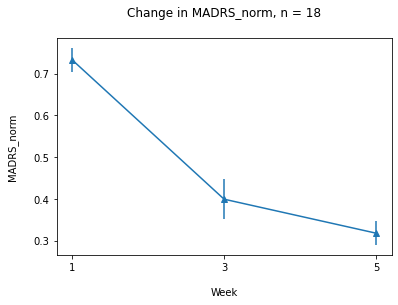

In [23]:
aov, pt = rm_anova('MADRS_norm', dft1, dft2, dft3, resp)
display(aov)
display(pt)
plot('MADRS_norm', dft1, dft2, dft3, resp)

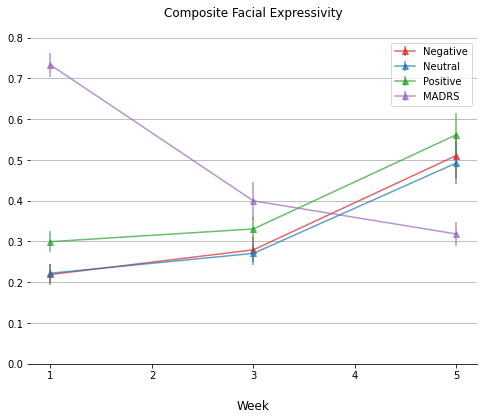

In [24]:
plot_paper_img('MADRS_norm', 'fac_ComIntSoft_mean', dft1, dft2, dft3, resp, title='Composite Facial Expressivity')

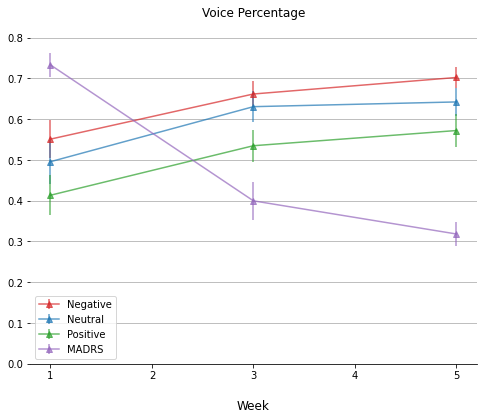

In [25]:
plot_paper_img('MADRS_norm', 'aco_voicePct_mean', dft1, dft2, dft3, resp, title='Voice Percentage')

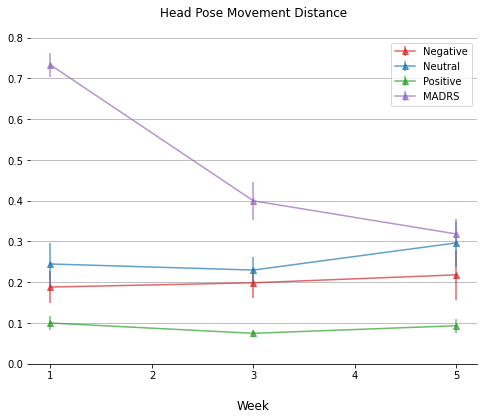

In [26]:
plot_paper_img('MADRS_norm', 'mov_HposeDist_mean', dft1, dft2, dft3, resp, title='Head Pose Movement Distance')

### Selecting subset of features to analyze

In [27]:
dbm_list = biomarkers + new_biomarkers
dbms = [x for x in dbm_list if 'fac' in x and 'mean' in x or 'mov_' in x or 'aco_voicePct' in x or 'aco_HRF' in x or 'aco_QOQ' in x or 'nlp_sentiment' in x ]
dbms = [x for x in dbms if 'fac_tremor' not in x and 'mov_Amp' not in x and 'mov_Freq' not in x]

## Repeated Measures ANOVA and Pairwise Comparison

aco_HRF_mean_negimg, n = 11


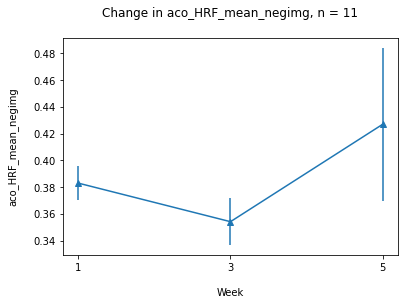

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.029962,2,0.014981,1.44038,0.255118,0.254611,0.099747,0.594455,False,0.317787,0.005749
1,Error,0.270420,26,0.010401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.380,0.357,0.023,0.042,two-sided,0.549,0.832,0.205
1,1,3,0.380,0.427,-0.047,0.044,two-sided,-1.073,0.530,-0.418
2,2,3,0.357,0.427,-0.070,0.045,two-sided,-1.571,0.260,-0.622


aco_HRF_mean_neuimg, n = 11


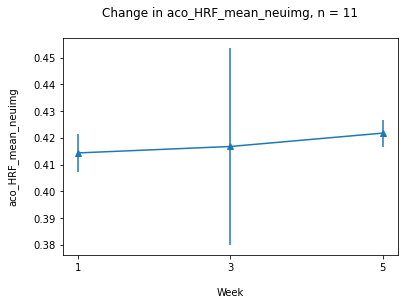

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.000778,2,0.000389,0.106632,0.899248,0.772142,0.008136,0.548711,True,417.480402,1.0
1,Error,0.094861,26,0.003649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.412,0.421,-0.009,0.026,two-sided,-0.340,0.9,-0.127
1,1,3,0.412,0.422,-0.010,0.027,two-sided,-0.360,0.9,-0.140
2,2,3,0.421,0.422,-0.001,0.028,two-sided,-0.034,0.9,-0.013


aco_HRF_mean_posimg, n = 11


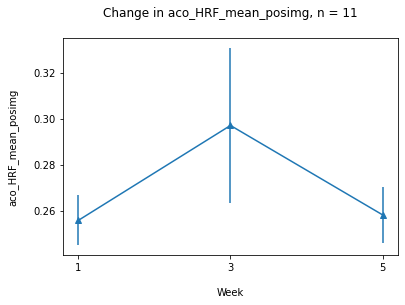

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.017875,2,0.008937,-102.115257,1.0,1.0,1.145878,0.67039,False,0.50833,0.047606
1,Error,-0.002276,26,-0.000088,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.243,0.294,-0.051,0.029,two-sided,-1.728,0.197,-0.645
1,1,3,0.243,0.258,-0.015,0.031,two-sided,-0.497,0.862,-0.194
2,2,3,0.294,0.258,0.035,0.031,two-sided,1.136,0.493,0.449


aco_QOQ_mean_negimg, n = 11


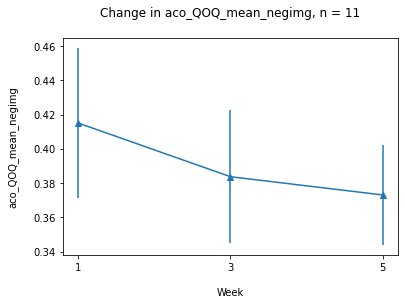

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.003558,2,0.001779,0.904766,0.417,0.403465,0.065069,0.843702,True,0.814748,0.397744
1,Error,0.051126,26,0.001966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.391,0.397,-0.006,0.054,two-sided,-0.108,0.9,-0.040
1,1,3,0.391,0.373,0.018,0.057,two-sided,0.315,0.9,0.123
2,2,3,0.397,0.373,0.024,0.057,two-sided,0.412,0.9,0.163


aco_QOQ_mean_neuimg, n = 11


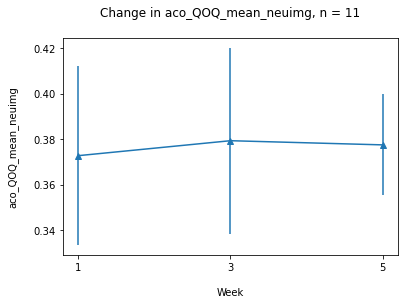

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.003478,2,0.001739,0.972769,0.391373,0.391084,0.069619,0.995453,True,0.995432,0.979608
1,Error,0.046482,26,0.001788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.362,0.384,-0.022,0.043,two-sided,-0.509,0.855,-0.190
1,1,3,0.362,0.378,-0.016,0.045,two-sided,-0.349,0.900,-0.136
2,2,3,0.384,0.378,0.006,0.046,two-sided,0.136,0.900,0.054


aco_QOQ_mean_posimg, n = 11


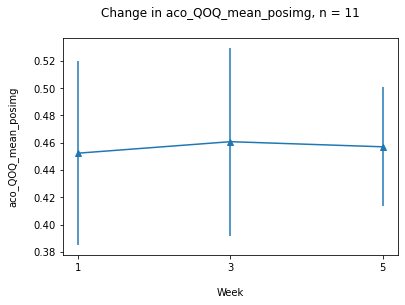

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.002702,2,0.001351,0.144462,0.866177,0.799957,0.01099,0.72925,True,0.628729,0.123904
1,Error,0.243176,26,0.009353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.438,0.454,-0.016,0.073,two-sided,-0.217,0.9,-0.081
1,1,3,0.438,0.457,-0.019,0.077,two-sided,-0.247,0.9,-0.096
2,2,3,0.454,0.457,-0.003,0.078,two-sided,-0.039,0.9,-0.015


aco_voicePct_mean_negimg, n = 11


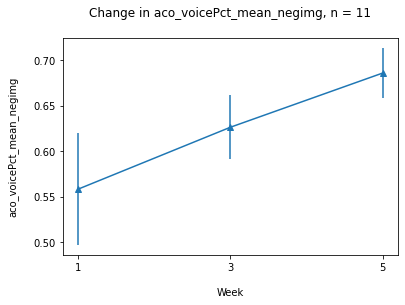

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.126132,2,0.063066,4.655603,0.018698,0.035333,0.26369,0.677698,True,0.524416,0.05477
1,Error,0.352202,26,0.013546,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.555,0.662,-0.107,0.060,two-sided,-1.793,0.175,-0.670
1,1,3,0.555,0.686,-0.131,0.062,two-sided,-2.095,0.094,-0.816
2,2,3,0.662,0.686,-0.024,0.063,two-sided,-0.375,0.900,-0.148


aco_voicePct_mean_neuimg, n = 11


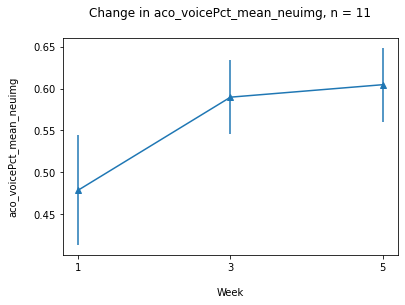

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.130333,2,0.065166,5.596521,0.00952,0.013967,0.300945,0.849057,True,0.822223,0.414432
1,Error,0.302747,26,0.011644,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.482,0.602,-0.120,0.068,two-sided,-1.763,0.185,-0.659
1,1,3,0.482,0.605,-0.123,0.071,two-sided,-1.730,0.197,-0.674
2,2,3,0.602,0.605,-0.003,0.072,two-sided,-0.044,0.900,-0.017


aco_voicePct_mean_posimg, n = 11


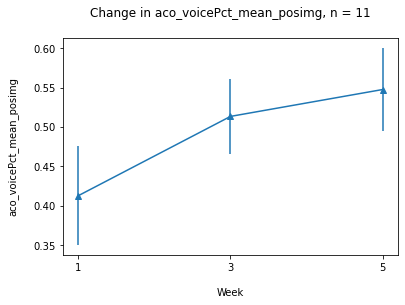

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.167948,2,0.083974,3.595049,0.041835,0.04572,0.216634,0.932264,True,0.927343,0.712166
1,Error,0.607314,26,0.023358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.409,0.546,-0.137,0.071,two-sided,-1.945,0.129,-0.727
1,1,3,0.409,0.547,-0.139,0.074,two-sided,-1.879,0.148,-0.732
2,2,3,0.546,0.547,-0.001,0.075,two-sided,-0.019,0.900,-0.007


fac_AngIntHard_mean_negimg, n = 12


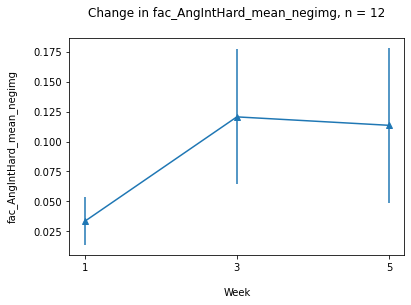

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.058908,2,0.029454,2.125174,0.138271,0.14441,0.131792,0.896364,True,0.884382,0.541003
1,Error,0.388068,28,0.013860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.031,0.106,-0.075,0.062,two-sided,-1.209,0.450,-0.437
1,1,3,0.031,0.114,-0.083,0.064,two-sided,-1.282,0.408,-0.481
2,2,3,0.106,0.114,-0.008,0.066,two-sided,-0.120,0.900,-0.046


fac_AngIntHard_mean_neuimg, n = 12


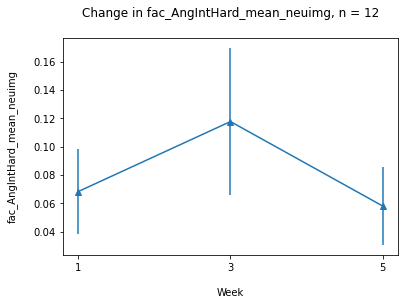

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.021453,2,0.010727,1.530867,0.233912,0.238374,0.098569,0.649918,False,0.461345,0.020899
1,Error,0.196193,28,0.007007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.061,0.108,-0.047,0.047,two-sided,-0.999,0.572,-0.361
1,1,3,0.061,0.058,0.003,0.049,two-sided,0.066,0.900,0.025
2,2,3,0.108,0.058,0.050,0.050,two-sided,1.008,0.567,0.384


fac_AngIntHard_mean_posimg, n = 12


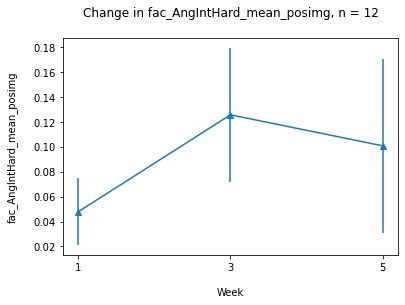

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.027077,2,0.013538,0.603422,0.553895,0.486039,0.041321,0.637193,False,0.430616,0.014807
1,Error,0.628211,28,0.022436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.052,0.108,-0.056,0.066,two-sided,-0.859,0.653,-0.310
1,1,3,0.052,0.101,-0.049,0.068,two-sided,-0.722,0.732,-0.271
2,2,3,0.108,0.101,0.007,0.069,two-sided,0.100,0.900,0.038


fac_AngIntSoft_mean_negimg, n = 12


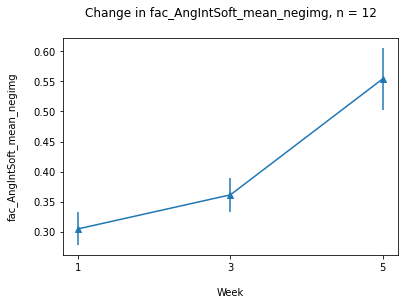

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.411543,2,0.205772,19.962929,0.000004,0.000026,0.587786,0.809893,True,0.765268,0.262464
1,Error,0.288615,28,0.010308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.314,0.366,-0.052,0.046,two-sided,-1.132,0.495,-0.409
1,1,3,0.314,0.554,-0.240,0.047,two-sided,-5.055,0.001,-1.899
2,2,3,0.366,0.554,-0.188,0.048,two-sided,-3.907,0.001,-1.489


fac_AngIntSoft_mean_neuimg, n = 12


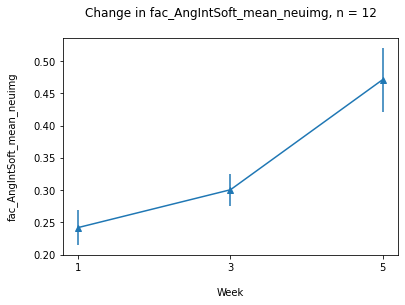

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.338301,2,0.169150,13.27572,0.000088,0.000223,0.486723,0.862388,True,0.840429,0.41928
1,Error,0.356757,28,0.012741,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.252,0.304,-0.052,0.043,two-sided,-1.196,0.458,-0.432
1,1,3,0.252,0.471,-0.219,0.045,two-sided,-4.852,0.001,-1.822
2,2,3,0.304,0.471,-0.167,0.046,two-sided,-3.647,0.001,-1.389


fac_AngIntSoft_mean_posimg, n = 12


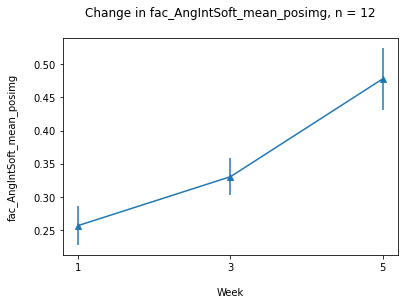

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.320061,2,0.160030,21.189739,0.000002,0.000007,0.602157,0.902564,True,0.892046,0.564854
1,Error,0.211463,28,0.007552,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.261,0.333,-0.072,0.044,two-sided,-1.625,0.237,-0.587
1,1,3,0.261,0.478,-0.217,0.046,two-sided,-4.714,0.001,-1.770
2,2,3,0.333,0.478,-0.145,0.047,two-sided,-3.106,0.006,-1.183


fac_AngPres_mean_negimg, n = 12


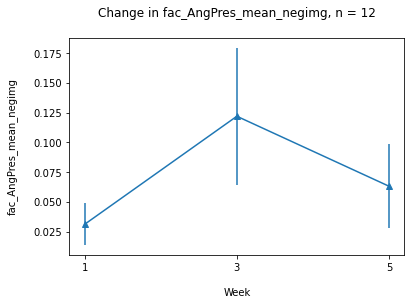

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.044426,2,0.022213,2.395819,0.109529,0.130786,0.146124,0.6884,False,0.547356,0.04913
1,Error,0.259605,28,0.009272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.029,0.108,-0.078,0.049,two-sided,-1.588,0.253,-0.574
1,1,3,0.029,0.063,-0.034,0.051,two-sided,-0.656,0.770,-0.247
2,2,3,0.108,0.063,0.045,0.052,two-sided,0.854,0.656,0.325


fac_AngPres_mean_neuimg, n = 12


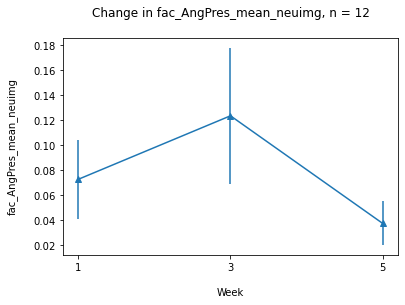

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.039647,2,0.019823,2.538106,0.097049,0.121397,0.15347,0.65825,False,0.480821,0.025699
1,Error,0.218688,28,0.007810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.066,0.114,-0.049,0.046,two-sided,-1.051,0.542,-0.380
1,1,3,0.066,0.038,0.028,0.048,two-sided,0.581,0.813,0.218
2,2,3,0.114,0.038,0.077,0.049,two-sided,1.565,0.263,0.596


fac_AngPres_mean_posimg, n = 12


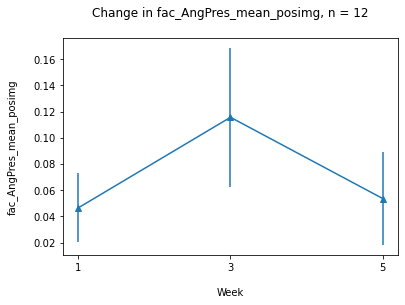

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.021395,2,0.010698,0.921711,0.409573,0.378737,0.06177,0.675128,False,0.518799,0.037583
1,Error,0.324976,28,0.011606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.049,0.099,-0.050,0.050,two-sided,-1.007,0.568,-0.364
1,1,3,0.049,0.054,-0.004,0.052,two-sided,-0.086,0.900,-0.032
2,2,3,0.099,0.054,0.046,0.053,two-sided,0.866,0.649,0.330


fac_ComIntHard_mean_negimg, n = 12


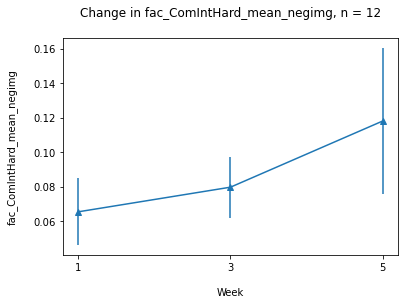

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.021063,2,0.010532,2.795885,0.078154,0.104698,0.166463,0.641474,False,0.44109,0.016697
1,Error,0.105470,28,0.003767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.063,0.079,-0.016,0.035,two-sided,-0.468,0.878,-0.169
1,1,3,0.063,0.118,-0.055,0.037,two-sided,-1.514,0.286,-0.569
2,2,3,0.079,0.118,-0.039,0.037,two-sided,-1.049,0.543,-0.400


fac_ComIntHard_mean_neuimg, n = 12


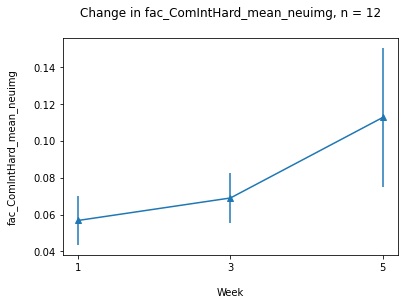

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.023575,2,0.011787,3.710922,0.037189,0.066863,0.209527,0.579877,True,484.494581,1.0
1,Error,0.088939,28,0.003176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.055,0.068,-0.012,0.030,two-sided,-0.410,0.900,-0.148
1,1,3,0.055,0.113,-0.057,0.031,two-sided,-1.859,0.153,-0.698
2,2,3,0.068,0.113,-0.045,0.031,two-sided,-1.443,0.321,-0.550


fac_ComIntHard_mean_posimg, n = 12


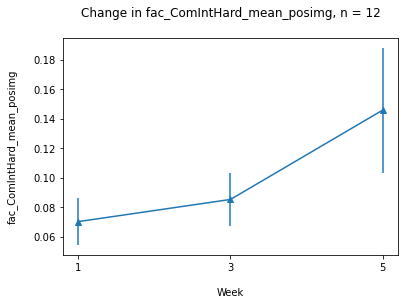

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.040352,2,0.020176,3.375645,0.048598,0.079172,0.194275,0.58698,False,0.296365,0.002286
1,Error,0.167354,28,0.005977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.073,0.082,-0.008,0.034,two-sided,-0.244,0.900,-0.088
1,1,3,0.073,0.146,-0.073,0.036,two-sided,-2.022,0.110,-0.759
2,2,3,0.082,0.146,-0.064,0.036,two-sided,-1.760,0.186,-0.670


fac_ComIntSoft_mean_negimg, n = 12


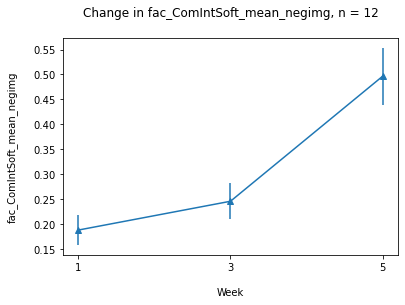

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.675646,2,0.337823,36.94809,1.399593e-08,4.225735e-07,0.725211,0.775356,True,0.71027,0.180766
1,Error,0.256009,28,0.009143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.191,0.250,-0.059,0.054,two-sided,-1.096,0.516,-0.396
1,1,3,0.191,0.497,-0.305,0.056,two-sided,-5.454,0.001,-2.048
2,2,3,0.250,0.497,-0.246,0.057,two-sided,-4.334,0.001,-1.651


fac_ComIntSoft_mean_neuimg, n = 12


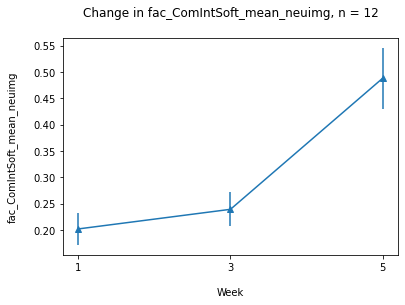

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.609965,2,0.304983,32.598636,4.881661e-08,7.248138e-07,0.699562,0.806546,True,0.760145,0.253794
1,Error,0.261959,28,0.009356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.205,0.242,-0.037,0.052,two-sided,-0.722,0.732,-0.261
1,1,3,0.205,0.488,-0.284,0.054,two-sided,-5.259,0.001,-1.975
2,2,3,0.242,0.488,-0.246,0.055,two-sided,-4.495,0.001,-1.713


fac_ComIntSoft_mean_posimg, n = 12


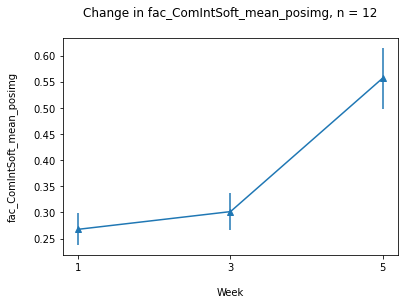

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.639109,2,0.319554,40.66551,5.221615e-09,5.968820e-07,0.743897,0.706507,True,0.584586,0.068272
1,Error,0.220027,28,0.007858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.269,0.301,-0.032,0.053,two-sided,-0.609,0.797,-0.220
1,1,3,0.269,0.557,-0.288,0.055,two-sided,-5.213,0.001,-1.958
2,2,3,0.301,0.557,-0.256,0.056,two-sided,-4.557,0.001,-1.736


fac_ConIntHard_mean_negimg, n = 12


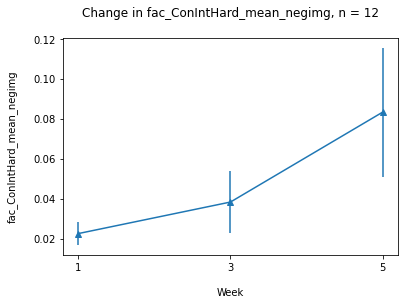

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.019110,2,0.009555,2.634437,0.08947,0.113985,0.158372,0.661515,False,0.488319,0.027766
1,Error,0.101553,28,0.003627,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.031,0.046,-0.015,0.027,two-sided,-0.552,0.830,-0.200
1,1,3,0.031,0.083,-0.053,0.028,two-sided,-1.854,0.155,-0.696
2,2,3,0.046,0.083,-0.038,0.029,two-sided,-1.303,0.396,-0.496


fac_ConIntHard_mean_neuimg, n = 12


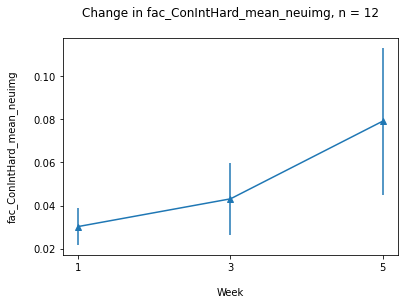

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.015169,2,0.007585,2.083572,0.143363,0.166015,0.129547,0.602276,True,443.831449,1.0
1,Error,0.101925,28,0.003640,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.033,0.043,-0.010,0.028,two-sided,-0.363,0.900,-0.131
1,1,3,0.033,0.079,-0.046,0.029,two-sided,-1.601,0.247,-0.601
2,2,3,0.043,0.079,-0.036,0.029,two-sided,-1.233,0.436,-0.470


fac_ConIntHard_mean_posimg, n = 12


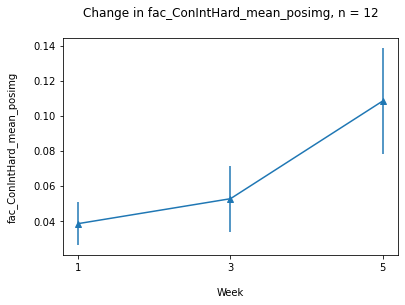

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.026754,2,0.013377,3.449221,0.045807,0.058386,0.197672,0.803147,True,0.754898,0.245155
1,Error,0.108592,28,0.003878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.049,0.057,-0.009,0.029,two-sided,-0.299,0.900,-0.108
1,1,3,0.049,0.108,-0.060,0.030,two-sided,-1.966,0.123,-0.739
2,2,3,0.057,0.108,-0.051,0.031,two-sided,-1.654,0.226,-0.630


fac_ConIntSoft_mean_negimg, n = 12


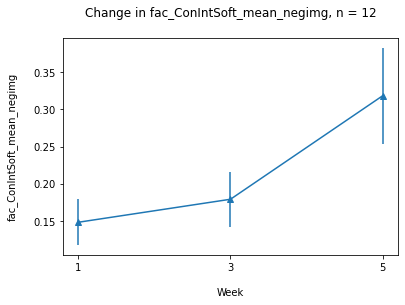

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.201134,2,0.100567,6.420901,0.005067,0.010142,0.314428,0.774562,True,0.708947,0.179089
1,Error,0.438548,28,0.015662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.155,0.177,-0.022,0.057,two-sided,-0.386,0.900,-0.139
1,1,3,0.155,0.318,-0.163,0.059,two-sided,-2.753,0.017,-1.034
2,2,3,0.177,0.318,-0.141,0.060,two-sided,-2.346,0.052,-0.894


fac_ConIntSoft_mean_neuimg, n = 12


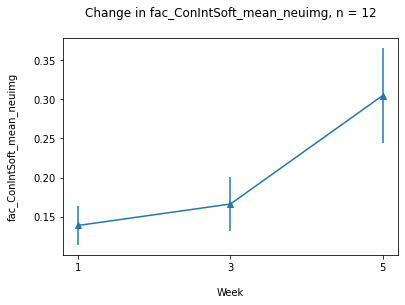

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.211406,2,0.105703,8.3044,0.001473,0.004081,0.372321,0.756166,True,0.677539,0.142782
1,Error,0.356399,28,0.012729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.136,0.163,-0.027,0.052,two-sided,-0.523,0.847,-0.189
1,1,3,0.136,0.305,-0.169,0.054,two-sided,-3.113,0.006,-1.169
2,2,3,0.163,0.305,-0.142,0.055,two-sided,-2.571,0.029,-0.979


fac_ConIntSoft_mean_posimg, n = 12


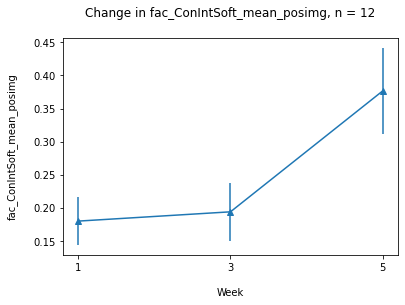

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.318446,2,0.159223,8.812113,0.001075,0.003872,0.386291,0.713234,True,0.597935,0.076431
1,Error,0.505923,28,0.018069,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.176,0.192,-0.016,0.061,two-sided,-0.258,0.900,-0.093
1,1,3,0.176,0.377,-0.201,0.063,two-sided,-3.177,0.005,-1.193
2,2,3,0.192,0.377,-0.185,0.064,two-sided,-2.884,0.012,-1.099


fac_ConPres_mean_negimg, n = 12


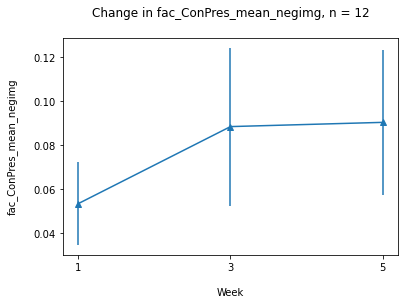

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.004242,2,0.002121,0.292262,0.748823,0.74308,0.020449,0.973335,True,0.972604,0.870325
1,Error,0.203183,28,0.007257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.070,0.091,-0.021,0.040,two-sided,-0.537,0.838,-0.194
1,1,3,0.070,0.090,-0.021,0.042,two-sided,-0.499,0.860,-0.187
2,2,3,0.091,0.090,0.001,0.042,two-sided,0.016,0.900,0.006


fac_ConPres_mean_neuimg, n = 12


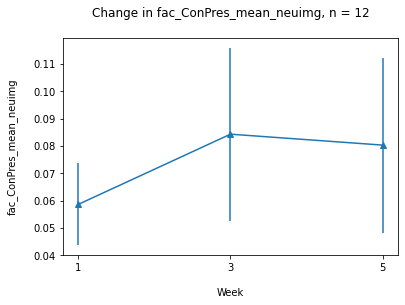

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.001997,2,0.000998,0.186854,0.830591,0.747865,0.013171,0.68692,False,0.544226,0.047741
1,Error,0.149596,28,0.005343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.066,0.08,-0.014,0.035,two-sided,-0.407,0.9,-0.147
1,1,3,0.066,0.08,-0.015,0.037,two-sided,-0.400,0.9,-0.150
2,2,3,0.080,0.08,-0.000,0.037,two-sided,-0.009,0.9,-0.004


fac_ConPres_mean_posimg, n = 12


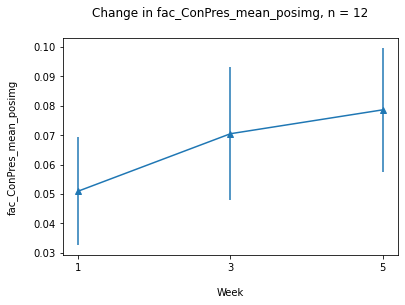

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.000725,2,0.000363,0.088495,0.915562,0.907042,0.006281,0.949171,True,0.946449,0.759428
1,Error,0.114696,28,0.004096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.070,0.069,0.002,0.031,two-sided,0.053,0.9,0.019
1,1,3,0.070,0.079,-0.008,0.032,two-sided,-0.262,0.9,-0.098
2,2,3,0.069,0.079,-0.010,0.032,two-sided,-0.308,0.9,-0.117


fac_DisIntHard_mean_negimg, n = 12


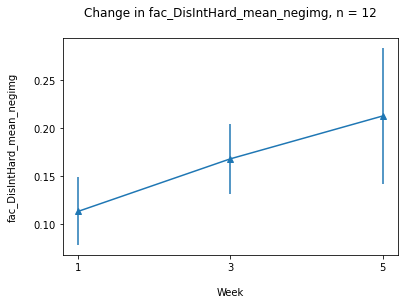

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.063986,2,0.031993,1.2397,0.304876,0.297748,0.081347,0.724184,True,0.619135,0.090976
1,Error,0.722601,28,0.025807,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.116,0.171,-0.055,0.062,two-sided,-0.900,0.629,-0.325
1,1,3,0.116,0.213,-0.097,0.064,two-sided,-1.509,0.289,-0.567
2,2,3,0.171,0.213,-0.041,0.065,two-sided,-0.635,0.782,-0.242


fac_DisIntHard_mean_neuimg, n = 12


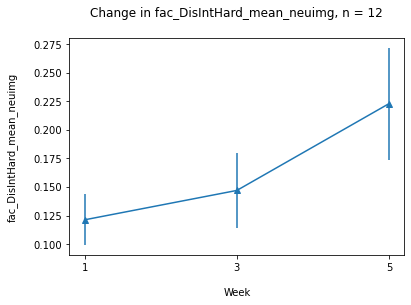

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.052552,2,0.026276,3.158926,0.057934,0.066332,0.184098,0.871103,True,0.852031,0.449031
1,Error,0.232904,28,0.008318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.135,0.167,-0.033,0.049,two-sided,-0.668,0.763,-0.241
1,1,3,0.135,0.223,-0.088,0.051,two-sided,-1.739,0.193,-0.653
2,2,3,0.167,0.223,-0.056,0.052,two-sided,-1.081,0.525,-0.412


fac_DisIntHard_mean_posimg, n = 12


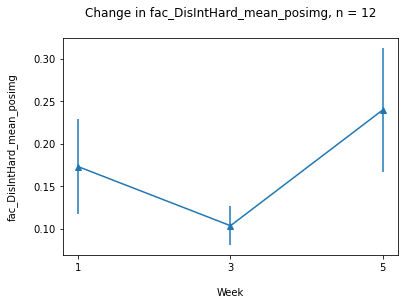

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.097661,2,0.048830,1.832108,0.178752,0.190312,0.115721,0.7345,True,0.638529,0.106146
1,Error,0.746274,28,0.026653,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.177,0.117,0.060,0.069,two-sided,0.867,0.649,0.313
1,1,3,0.177,0.240,-0.063,0.072,two-sided,-0.867,0.649,-0.325
2,2,3,0.117,0.240,-0.123,0.073,two-sided,-1.672,0.219,-0.637


fac_DisIntSoft_mean_negimg, n = 12


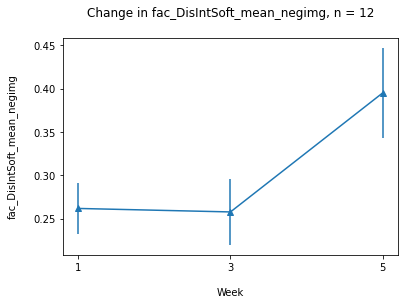

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.141631,2,0.070815,9.426598,0.000741,0.001229,0.402389,0.894346,True,0.881865,0.533348
1,Error,0.210344,28,0.007512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.254,0.286,-0.032,0.054,two-sided,-0.595,0.805,-0.215
1,1,3,0.254,0.395,-0.141,0.056,two-sided,-2.518,0.033,-0.946
2,2,3,0.286,0.395,-0.109,0.057,two-sided,-1.917,0.137,-0.730


fac_DisIntSoft_mean_neuimg, n = 12


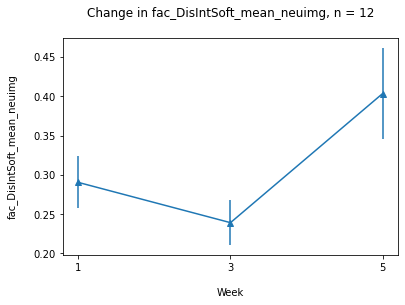

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.157143,2,0.078571,11.998846,0.000172,0.00094,0.461515,0.72412,True,0.619013,0.090887
1,Error,0.183351,28,0.006548,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.287,0.254,0.033,0.054,two-sided,0.611,0.796,0.221
1,1,3,0.287,0.404,-0.117,0.057,two-sided,-2.056,0.102,-0.772
2,2,3,0.254,0.404,-0.150,0.058,two-sided,-2.601,0.027,-0.991


fac_DisIntSoft_mean_posimg, n = 12


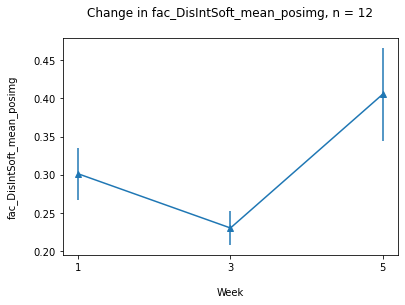

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.173209,2,0.086604,8.999791,0.000959,0.003555,0.391299,0.713374,True,0.59821,0.076607
1,Error,0.269442,28,0.009623,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.290,0.245,0.045,0.055,two-sided,0.822,0.674,0.297
1,1,3,0.290,0.405,-0.115,0.057,two-sided,-2.014,0.111,-0.757
2,2,3,0.245,0.405,-0.160,0.058,two-sided,-2.760,0.017,-1.051


fac_DisPres_mean_negimg, n = 12


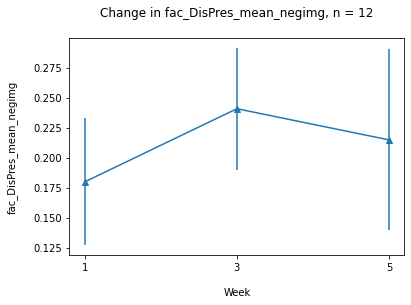

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.023168,2,0.011584,0.310176,0.735805,0.685547,0.021675,0.790332,True,0.734709,0.21408
1,Error,1.045697,28,0.037346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.184,0.240,-0.056,0.074,two-sided,-0.759,0.711,-0.274
1,1,3,0.184,0.215,-0.031,0.077,two-sided,-0.404,0.900,-0.152
2,2,3,0.240,0.215,0.025,0.079,two-sided,0.320,0.900,0.122


fac_DisPres_mean_neuimg, n = 12


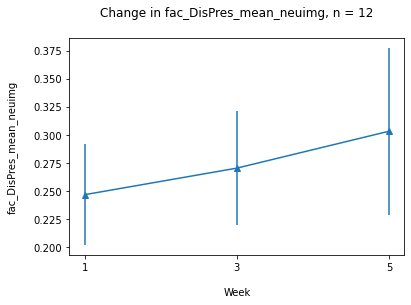

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.003644,2,0.001822,0.514437,0.603378,0.585359,0.035443,0.901521,True,0.890764,0.560806
1,Error,0.099180,28,0.003542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.281,0.286,-0.005,0.079,two-sided,-0.062,0.9,-0.022
1,1,3,0.281,0.303,-0.023,0.082,two-sided,-0.276,0.9,-0.103
2,2,3,0.286,0.303,-0.018,0.083,two-sided,-0.213,0.9,-0.081


fac_DisPres_mean_posimg, n = 12


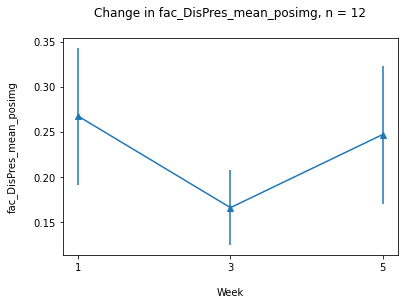

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.090356,2,0.045178,1.333998,0.279651,0.277937,0.086996,0.786778,True,0.728994,0.205883
1,Error,0.948265,28,0.033867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.28,0.170,0.110,0.083,two-sided,1.313,0.390,0.474
1,1,3,0.28,0.247,0.033,0.087,two-sided,0.375,0.900,0.141
2,2,3,0.17,0.247,-0.077,0.088,two-sided,-0.871,0.646,-0.332


fac_FeaIntHard_mean_negimg, n = 12


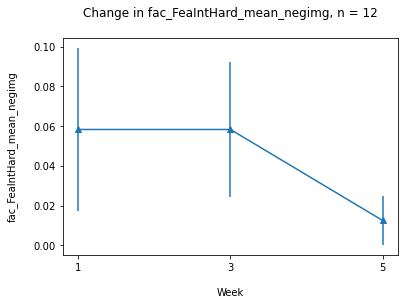

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.010944,2,0.005472,0.699073,0.505514,0.458318,0.047559,0.691075,True,0.552978,0.051706
1,Error,0.219172,28,0.007828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.047,0.050,-0.003,0.039,two-sided,-0.086,0.900,-0.031
1,1,3,0.047,0.012,0.034,0.040,two-sided,0.850,0.658,0.319
2,2,3,0.050,0.012,0.038,0.041,two-sided,0.919,0.619,0.350


fac_FeaIntHard_mean_neuimg, n = 12


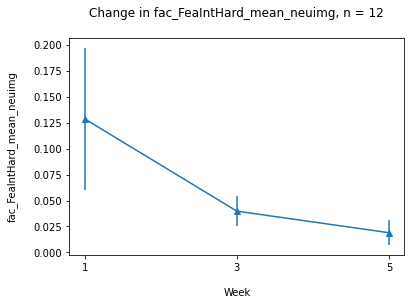

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.093168,2,0.046584,3.825837,0.03397,0.065507,0.214623,0.553023,False,0.191756,0.000259
1,Error,0.340934,28,0.012176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.130,0.047,0.083,0.054,two-sided,1.541,0.274,0.557
1,1,3,0.130,0.019,0.111,0.056,two-sided,1.979,0.120,0.743
2,2,3,0.047,0.019,0.028,0.057,two-sided,0.492,0.864,0.188


fac_FeaIntHard_mean_posimg, n = 12


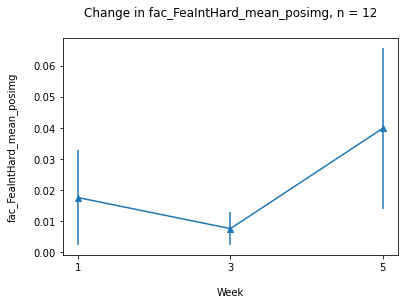

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.007210,2,0.003605,1.178392,0.322576,0.310558,0.077636,0.689391,True,0.549445,0.050075
1,Error,0.085654,28,0.003059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.021,0.007,0.014,0.022,two-sided,0.648,0.775,0.234
1,1,3,0.021,0.040,-0.019,0.023,two-sided,-0.847,0.660,-0.318
2,2,3,0.007,0.040,-0.033,0.023,two-sided,-1.446,0.319,-0.551


fac_FeaIntSoft_mean_negimg, n = 12


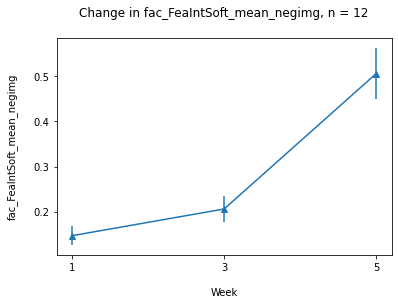

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.968288,2,0.484144,60.380029,7.004928e-11,1.410720e-08,0.811777,0.739594,True,0.647907,0.114173
1,Error,0.224512,28,0.008018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.141,0.210,-0.069,0.048,two-sided,-1.438,0.323,-0.519
1,1,3,0.141,0.506,-0.365,0.050,two-sided,-7.266,0.001,-2.729
2,2,3,0.210,0.506,-0.296,0.051,two-sided,-5.795,0.001,-2.208


fac_FeaIntSoft_mean_neuimg, n = 12


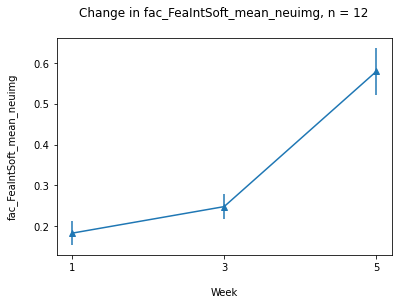

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,1.144509,2,0.572254,41.224867,4.528006e-09,6.919219e-08,0.746491,0.832317,True,0.798534,0.324689
1,Error,0.388676,28,0.013881,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.183,0.259,-0.076,0.051,two-sided,-1.491,0.298,-0.538
1,1,3,0.183,0.580,-0.397,0.053,two-sided,-7.477,0.001,-2.808
2,2,3,0.259,0.580,-0.321,0.054,two-sided,-5.953,0.001,-2.268


fac_FeaIntSoft_mean_posimg, n = 12


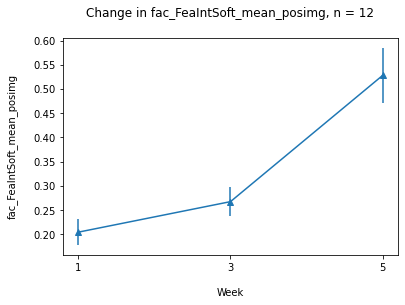

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.747287,2,0.373644,32.508912,5.015174e-08,8.507710e-07,0.698982,0.796636,True,0.744721,0.22907
1,Error,0.321820,28,0.011494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.205,0.275,-0.070,0.049,two-sided,-1.411,0.337,-0.510
1,1,3,0.205,0.528,-0.323,0.051,two-sided,-6.281,0.001,-2.359
2,2,3,0.275,0.528,-0.254,0.052,two-sided,-4.851,0.001,-1.848


fac_FeaPres_mean_negimg, n = 12


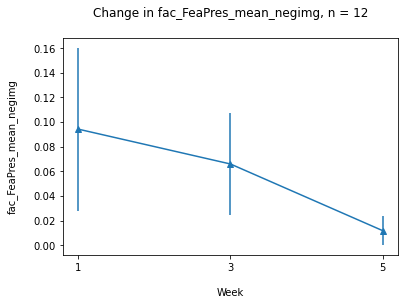

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.027684,2,0.013842,0.772854,0.471293,0.428675,0.052316,0.680059,False,0.529539,0.041638
1,Error,0.501492,28,0.017910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.075,0.057,0.019,0.056,two-sided,0.339,0.900,0.123
1,1,3,0.075,0.012,0.063,0.058,two-sided,1.096,0.516,0.412
2,2,3,0.057,0.012,0.045,0.059,two-sided,0.759,0.711,0.289


fac_FeaPres_mean_neuimg, n = 12


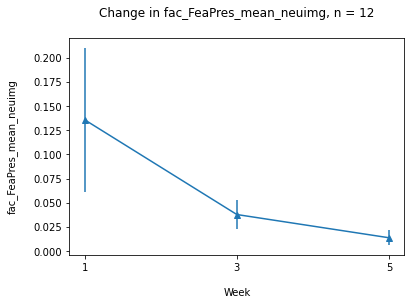

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.134438,2,0.067219,4.84374,0.015612,0.041305,0.257048,0.540734,False,0.150661,0.000078
1,Error,0.388571,28,0.013878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.148,0.048,0.100,0.062,two-sided,1.621,0.239,0.586
1,1,3,0.148,0.014,0.134,0.064,two-sided,2.086,0.095,0.784
2,2,3,0.048,0.014,0.034,0.065,two-sided,0.523,0.847,0.199


fac_FeaPres_mean_posimg, n = 12


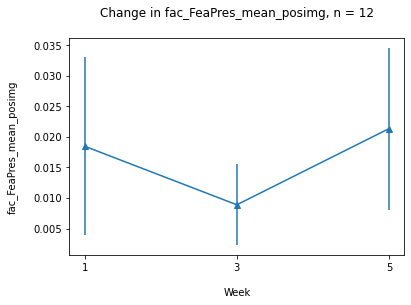

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.001980,2,0.000990,0.672933,0.518269,0.502402,0.045862,0.888715,True,0.87478,0.512263
1,Error,0.041185,28,0.001471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.023,0.008,0.015,0.016,two-sided,0.972,0.588,0.351
1,1,3,0.023,0.021,0.002,0.016,two-sided,0.094,0.900,0.035
2,2,3,0.008,0.021,-0.014,0.017,two-sided,-0.825,0.673,-0.314


fac_HapIntHard_mean_negimg, n = 12


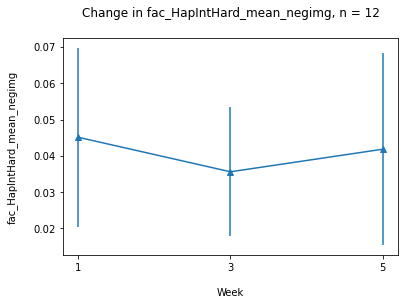

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.000784,2,0.000392,0.283617,0.755193,0.644537,0.019856,0.603505,True,1133.419545,1.0
1,Error,0.038707,28,0.001382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.037,0.031,0.006,0.028,two-sided,0.205,0.9,0.074
1,1,3,0.037,0.042,-0.005,0.030,two-sided,-0.174,0.9,-0.065
2,2,3,0.031,0.042,-0.011,0.030,two-sided,-0.365,0.9,-0.139


fac_HapIntHard_mean_neuimg, n = 12


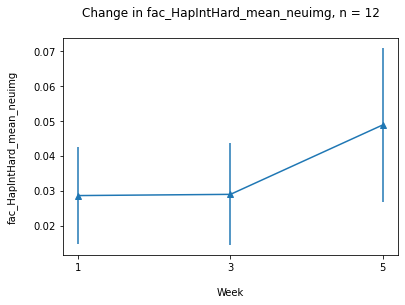

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.004957,2,0.002479,2.044307,0.148354,0.171954,0.127416,0.564853,True,1202.433668,1.0
1,Error,0.033948,28,0.001212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.024,0.025,-0.001,0.021,two-sided,-0.057,0.900,-0.020
1,1,3,0.024,0.049,-0.025,0.022,two-sided,-1.133,0.495,-0.426
2,2,3,0.025,0.049,-0.024,0.022,two-sided,-1.062,0.536,-0.405


fac_HapIntHard_mean_posimg, n = 12


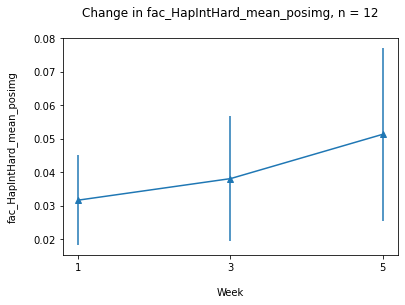

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.00386,2,0.001930,0.987024,0.38528,0.365611,0.065859,0.737592,True,0.644237,0.110976
1,Error,0.05475,28,0.001955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.028,0.033,-0.004,0.024,two-sided,-0.179,0.900,-0.065
1,1,3,0.028,0.051,-0.023,0.025,two-sided,-0.907,0.625,-0.341
2,2,3,0.033,0.051,-0.019,0.026,two-sided,-0.724,0.731,-0.276


fac_HapIntSoft_mean_negimg, n = 12


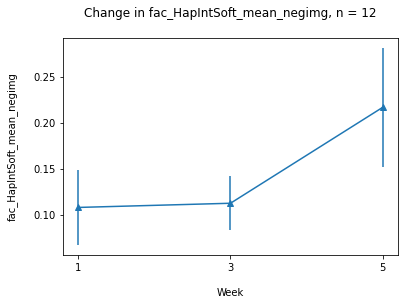

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.102392,2,0.051196,4.386329,0.022022,0.044489,0.238565,0.615312,False,0.374809,0.007397
1,Error,0.326808,28,0.011672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.105,0.110,-0.005,0.058,two-sided,-0.080,0.900,-0.029
1,1,3,0.105,0.217,-0.112,0.060,two-sided,-1.868,0.151,-0.701
2,2,3,0.110,0.217,-0.107,0.061,two-sided,-1.763,0.185,-0.672


fac_HapIntSoft_mean_neuimg, n = 12


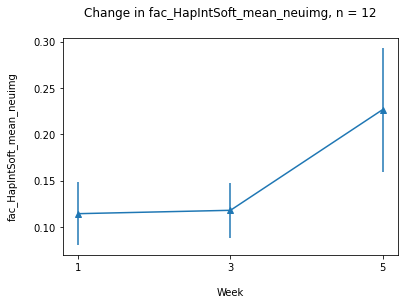

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.112119,2,0.056060,6.034043,0.006623,0.023243,0.301189,0.560836,False,0.216948,0.000481
1,Error,0.260136,28,0.009291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.111,0.113,-0.002,0.057,two-sided,-0.040,0.900,-0.014
1,1,3,0.111,0.227,-0.116,0.059,two-sided,-1.966,0.123,-0.738
2,2,3,0.113,0.227,-0.114,0.060,two-sided,-1.898,0.142,-0.723


fac_HapIntSoft_mean_posimg, n = 12


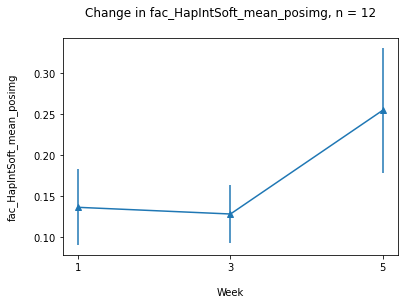

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.137459,2,0.068730,5.206398,0.011955,0.030606,0.271076,0.599148,False,0.330964,0.003971
1,Error,0.369627,28,0.013201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.137,0.120,0.017,0.068,two-sided,0.253,0.900,0.091
1,1,3,0.137,0.255,-0.118,0.070,two-sided,-1.674,0.218,-0.629
2,2,3,0.120,0.255,-0.135,0.072,two-sided,-1.887,0.145,-0.719


fac_HapPres_mean_negimg, n = 12


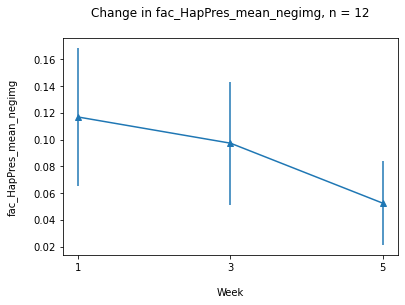

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.012430,2,0.006215,1.720352,0.197388,0.208899,0.109435,0.646092,False,0.452233,0.018915
1,Error,0.101156,28,0.003613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.095,0.084,0.011,0.054,two-sided,0.202,0.900,0.073
1,1,3,0.095,0.052,0.042,0.057,two-sided,0.745,0.719,0.280
2,2,3,0.084,0.052,0.031,0.058,two-sided,0.543,0.835,0.207


fac_HapPres_mean_neuimg, n = 12


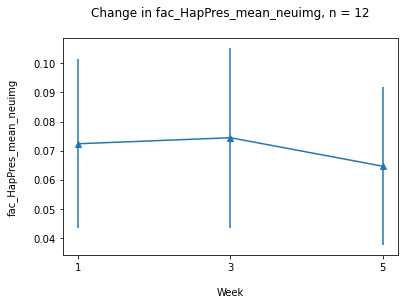

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.000139,2,0.00007,0.034017,0.966595,0.922449,0.002424,0.705195,True,0.581953,0.066748
1,Error,0.057388,28,0.00205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.061,0.065,-0.004,0.036,two-sided,-0.112,0.9,-0.041
1,1,3,0.061,0.065,-0.004,0.037,two-sided,-0.097,0.9,-0.037
2,2,3,0.065,0.065,0.000,0.038,two-sided,0.010,0.9,0.004


fac_HapPres_mean_posimg, n = 12


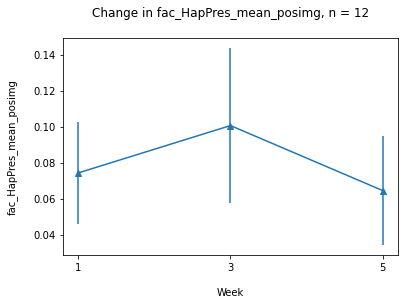

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.003864,2,0.001932,0.459658,0.636181,0.626787,0.031789,0.9509,True,0.948364,0.767142
1,Error,0.117696,28,0.004203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.067,0.086,-0.019,0.043,two-sided,-0.449,0.889,-0.162
1,1,3,0.067,0.065,0.002,0.045,two-sided,0.056,0.900,0.021
2,2,3,0.086,0.065,0.022,0.045,two-sided,0.479,0.872,0.182


fac_NegIntHard_mean_negimg, n = 12


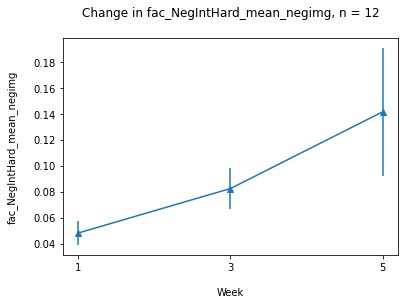

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.049866,2,0.024933,3.593462,0.04082,0.06919,0.20425,0.600774,False,0.335481,0.004249
1,Error,0.194276,28,0.006938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.056,0.088,-0.032,0.038,two-sided,-0.840,0.664,-0.303
1,1,3,0.056,0.142,-0.086,0.040,two-sided,-2.176,0.078,-0.817
2,2,3,0.088,0.142,-0.054,0.040,two-sided,-1.348,0.370,-0.514


fac_NegIntHard_mean_neuimg, n = 12


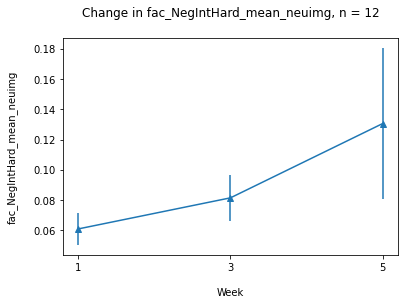

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.030951,2,0.015475,2.284946,0.120444,0.147624,0.14031,0.584814,False,0.290053,0.002053
1,Error,0.189638,28,0.006773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.064,0.082,-0.018,0.037,two-sided,-0.489,0.866,-0.177
1,1,3,0.064,0.131,-0.067,0.039,two-sided,-1.713,0.203,-0.643
2,2,3,0.082,0.131,-0.049,0.040,two-sided,-1.225,0.441,-0.467


fac_NegIntHard_mean_posimg, n = 12


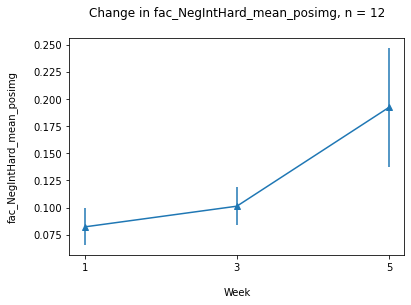

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.076193,2,0.038096,3.331487,0.050361,0.08355,0.192222,0.560494,False,0.21586,0.000469
1,Error,0.320187,28,0.011435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.093,0.104,-0.011,0.044,two-sided,-0.247,0.900,-0.089
1,1,3,0.093,0.192,-0.099,0.045,two-sided,-2.189,0.076,-0.822
2,2,3,0.104,0.192,-0.089,0.046,two-sided,-1.921,0.135,-0.732


fac_NegIntSoft_mean_negimg, n = 12


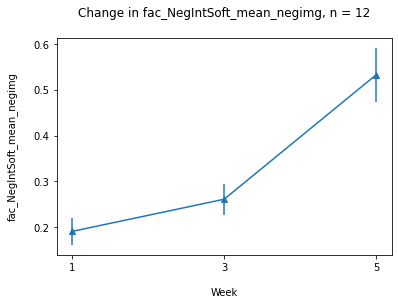

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.815437,2,0.407719,37.493827,1.205647e-08,1.977994e-07,0.728123,0.817223,True,0.776343,0.282013
1,Error,0.304480,28,0.010874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.196,0.268,-0.072,0.054,two-sided,-1.342,0.374,-0.485
1,1,3,0.196,0.533,-0.337,0.056,two-sided,-6.040,0.001,-2.269
2,2,3,0.268,0.533,-0.266,0.057,two-sided,-4.679,0.001,-1.782


fac_NegIntSoft_mean_neuimg, n = 12


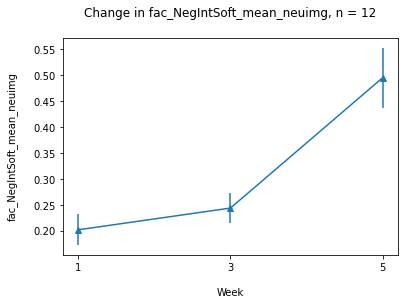

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.626530,2,0.313265,30.262848,1.002863e-07,0.000001,0.683708,0.819475,True,0.779706,0.288173
1,Error,0.289841,28,0.010351,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.206,0.249,-0.043,0.050,two-sided,-0.868,0.648,-0.313
1,1,3,0.206,0.495,-0.290,0.052,two-sided,-5.547,0.001,-2.083
2,2,3,0.249,0.495,-0.246,0.053,two-sided,-4.641,0.001,-1.768


fac_NegIntSoft_mean_posimg, n = 12


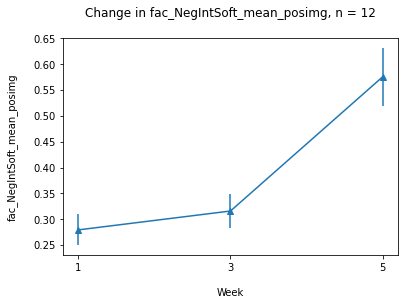

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.664062,2,0.332031,38.562378,9.043622e-09,7.289202e-07,0.73365,0.718747,True,0.60869,0.083557
1,Error,0.241086,28,0.008610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.280,0.318,-0.038,0.050,two-sided,-0.757,0.712,-0.273
1,1,3,0.280,0.576,-0.296,0.053,two-sided,-5.628,0.001,-2.114
2,2,3,0.318,0.576,-0.258,0.053,two-sided,-4.826,0.001,-1.839


fac_PosIntHard_mean_negimg, n = 12


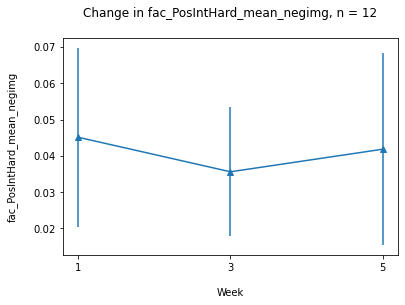

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.000784,2,0.000392,0.283617,0.755193,0.644537,0.019856,0.603505,True,1133.419545,1.0
1,Error,0.038707,28,0.001382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.037,0.031,0.006,0.028,two-sided,0.205,0.9,0.074
1,1,3,0.037,0.042,-0.005,0.030,two-sided,-0.174,0.9,-0.065
2,2,3,0.031,0.042,-0.011,0.030,two-sided,-0.365,0.9,-0.139


fac_PosIntHard_mean_neuimg, n = 12


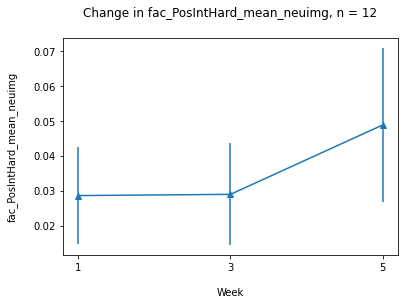

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.004957,2,0.002479,2.044307,0.148354,0.171954,0.127416,0.564853,True,1202.433668,1.0
1,Error,0.033948,28,0.001212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.024,0.025,-0.001,0.021,two-sided,-0.057,0.900,-0.020
1,1,3,0.024,0.049,-0.025,0.022,two-sided,-1.133,0.495,-0.426
2,2,3,0.025,0.049,-0.024,0.022,two-sided,-1.062,0.536,-0.405


fac_PosIntHard_mean_posimg, n = 12


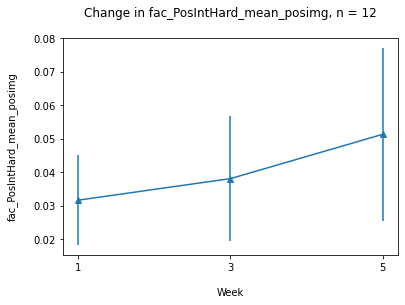

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.00386,2,0.001930,0.987024,0.38528,0.365611,0.065859,0.737592,True,0.644237,0.110976
1,Error,0.05475,28,0.001955,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.028,0.033,-0.004,0.024,two-sided,-0.179,0.900,-0.065
1,1,3,0.028,0.051,-0.023,0.025,two-sided,-0.907,0.625,-0.341
2,2,3,0.033,0.051,-0.019,0.026,two-sided,-0.724,0.731,-0.276


fac_PosIntSoft_mean_negimg, n = 12


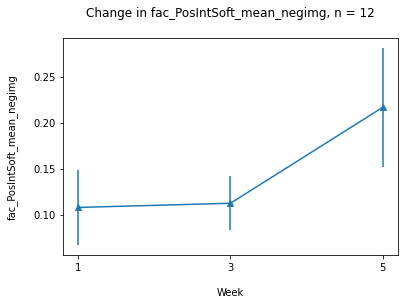

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.102392,2,0.051196,4.386329,0.022022,0.044489,0.238565,0.615312,False,0.374809,0.007397
1,Error,0.326808,28,0.011672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.105,0.110,-0.005,0.058,two-sided,-0.080,0.900,-0.029
1,1,3,0.105,0.217,-0.112,0.060,two-sided,-1.868,0.151,-0.701
2,2,3,0.110,0.217,-0.107,0.061,two-sided,-1.763,0.185,-0.672


fac_PosIntSoft_mean_neuimg, n = 12


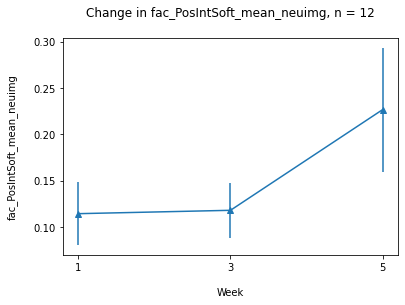

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.112119,2,0.056060,6.034043,0.006623,0.023243,0.301189,0.560836,False,0.216948,0.000481
1,Error,0.260136,28,0.009291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.111,0.113,-0.002,0.057,two-sided,-0.040,0.900,-0.014
1,1,3,0.111,0.227,-0.116,0.059,two-sided,-1.966,0.123,-0.738
2,2,3,0.113,0.227,-0.114,0.060,two-sided,-1.898,0.142,-0.723


fac_PosIntSoft_mean_posimg, n = 12


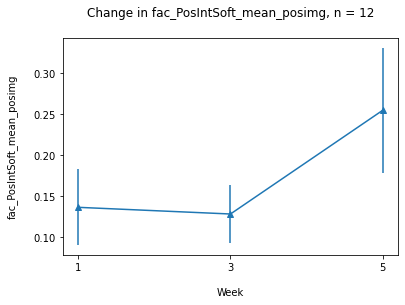

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.137459,2,0.068730,5.206398,0.011955,0.030606,0.271076,0.599148,False,0.330964,0.003971
1,Error,0.369627,28,0.013201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.137,0.120,0.017,0.068,two-sided,0.253,0.900,0.091
1,1,3,0.137,0.255,-0.118,0.070,two-sided,-1.674,0.218,-0.629
2,2,3,0.120,0.255,-0.135,0.072,two-sided,-1.887,0.145,-0.719


fac_SadIntHard_mean_negimg, n = 12


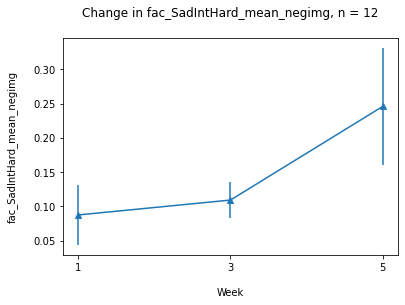

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.220854,2,0.110427,6.540018,0.004671,0.013418,0.318404,0.665877,False,0.498221,0.030698
1,Error,0.472775,28,0.016885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.078,0.094,-0.016,0.070,two-sided,-0.228,0.900,-0.082
1,1,3,0.078,0.246,-0.168,0.073,two-sided,-2.297,0.059,-0.863
2,2,3,0.094,0.246,-0.152,0.074,two-sided,-2.046,0.104,-0.779


fac_SadIntHard_mean_neuimg, n = 12


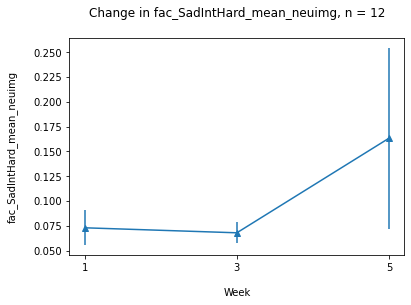

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.084854,2,0.042427,1.698589,0.201254,0.213474,0.1082,0.531165,False,0.117346,0.000022
1,Error,0.699375,28,0.024978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.067,0.060,0.007,0.065,two-sided,0.114,0.900,0.041
1,1,3,0.067,0.163,-0.096,0.068,two-sided,-1.412,0.336,-0.530
2,2,3,0.060,0.163,-0.104,0.069,two-sided,-1.498,0.294,-0.571


fac_SadIntHard_mean_posimg, n = 12


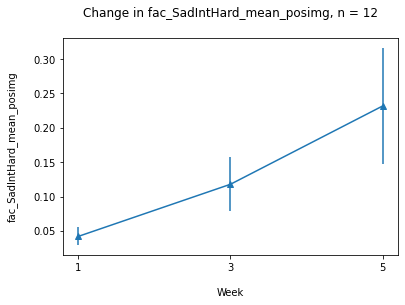

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.248523,2,0.124262,4.913659,0.014823,0.034026,0.259794,0.615508,False,0.375327,0.007448
1,Error,0.708092,28,0.025289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.041,0.101,-0.060,0.066,two-sided,-0.910,0.624,-0.329
1,1,3,0.041,0.232,-0.191,0.069,two-sided,-2.769,0.017,-1.040
2,2,3,0.101,0.232,-0.131,0.070,two-sided,-1.866,0.151,-0.711


fac_SadIntSoft_mean_negimg, n = 12


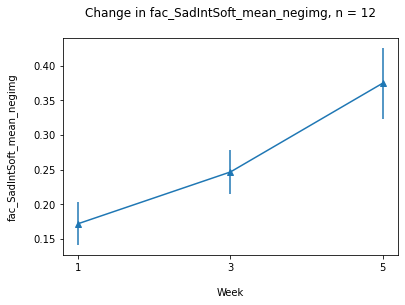

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.254194,2,0.127097,10.537424,0.000387,0.000716,0.429443,0.885979,True,0.871305,0.502171
1,Error,0.337722,28,0.012062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.181,0.246,-0.065,0.050,two-sided,-1.309,0.392,-0.473
1,1,3,0.181,0.374,-0.194,0.052,two-sided,-3.717,0.001,-1.396
2,2,3,0.246,0.374,-0.128,0.053,two-sided,-2.423,0.043,-0.923


fac_SadIntSoft_mean_neuimg, n = 12


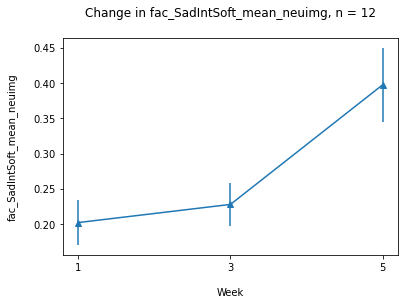

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.281442,2,0.140721,13.528731,0.000077,0.000165,0.49144,0.890178,True,0.876629,0.517701
1,Error,0.291246,28,0.010402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.207,0.227,-0.020,0.049,two-sided,-0.414,0.900,-0.149
1,1,3,0.207,0.398,-0.191,0.051,two-sided,-3.749,0.001,-1.408
2,2,3,0.227,0.398,-0.171,0.052,two-sided,-3.301,0.003,-1.257


fac_SadIntSoft_mean_posimg, n = 12


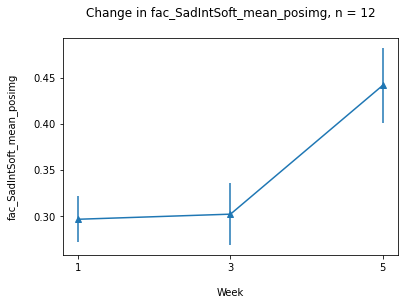

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.172635,2,0.086318,8.669769,0.001174,0.002299,0.382437,0.846263,True,0.818334,0.366988
1,Error,0.278772,28,0.009956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.305,0.294,0.012,0.043,two-sided,0.270,0.900,0.097
1,1,3,0.305,0.442,-0.137,0.045,two-sided,-3.040,0.007,-1.142
2,2,3,0.294,0.442,-0.148,0.046,two-sided,-3.247,0.004,-1.237


fac_SadPres_mean_negimg, n = 12


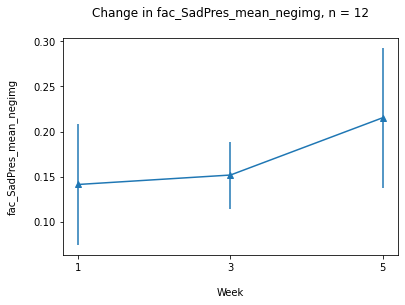

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.064626,2,0.032313,1.901298,0.168165,0.173835,0.119569,0.885145,True,0.870242,0.499113
1,Error,0.475864,28,0.016995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.126,0.130,-0.004,0.078,two-sided,-0.050,0.900,-0.018
1,1,3,0.126,0.215,-0.089,0.081,two-sided,-1.100,0.514,-0.413
2,2,3,0.130,0.215,-0.085,0.082,two-sided,-1.036,0.551,-0.395


fac_SadPres_mean_neuimg, n = 12


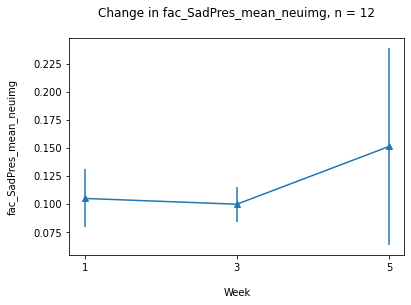

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.028919,2,0.014460,0.593774,0.559044,0.469049,0.040687,0.553862,False,0.194495,0.000278
1,Error,0.681856,28,0.024352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.099,0.088,0.011,0.066,two-sided,0.166,0.900,0.060
1,1,3,0.099,0.151,-0.052,0.069,two-sided,-0.762,0.709,-0.286
2,2,3,0.088,0.151,-0.063,0.070,two-sided,-0.907,0.625,-0.346


fac_SadPres_mean_posimg, n = 12


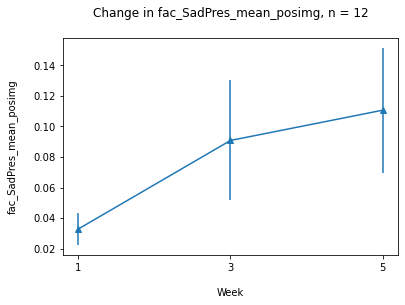

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.042053,2,0.021026,2.052139,0.147344,0.162513,0.127842,0.73127,True,0.632516,0.101241
1,Error,0.286889,28,0.010246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.032,0.078,-0.046,0.041,two-sided,-1.115,0.505,-0.403
1,1,3,0.032,0.111,-0.078,0.043,two-sided,-1.840,0.160,-0.691
2,2,3,0.078,0.111,-0.033,0.043,two-sided,-0.758,0.711,-0.289


fac_SurIntHard_mean_negimg, n = 12


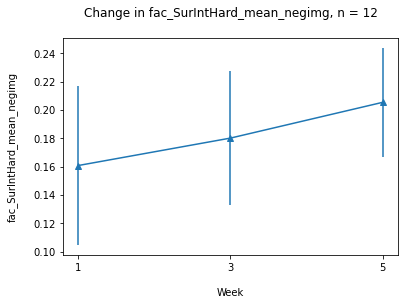

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.028780,2,0.014390,0.83316,0.445165,0.420388,0.056169,0.773428,True,0.707055,0.176712
1,Error,0.483608,28,0.017272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.140,0.174,-0.034,0.059,two-sided,-0.570,0.820,-0.206
1,1,3,0.140,0.205,-0.065,0.062,two-sided,-1.065,0.534,-0.400
2,2,3,0.174,0.205,-0.032,0.062,two-sided,-0.510,0.854,-0.194


fac_SurIntHard_mean_neuimg, n = 12


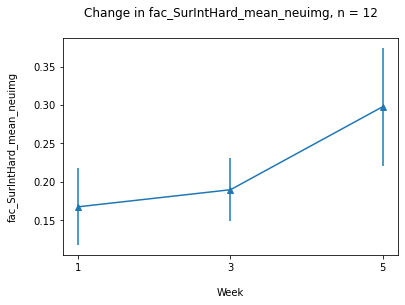

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.125932,2,0.062966,3.140162,0.058828,0.075289,0.183205,0.762194,True,0.687999,0.154148
1,Error,0.561450,28,0.020052,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.164,0.198,-0.034,0.071,two-sided,-0.477,0.873,-0.172
1,1,3,0.164,0.298,-0.134,0.074,two-sided,-1.813,0.168,-0.681
2,2,3,0.198,0.298,-0.100,0.075,two-sided,-1.334,0.378,-0.508


fac_SurIntHard_mean_posimg, n = 12


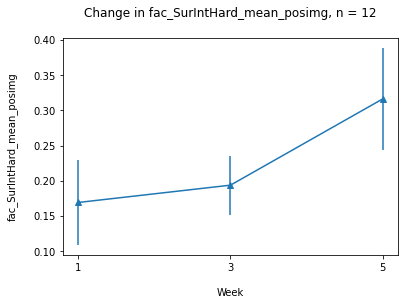

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.172682,2,0.086341,3.781567,0.035173,0.053496,0.212668,0.709453,True,0.590464,0.071774
1,Error,0.639298,28,0.022832,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.171,0.177,-0.007,0.074,two-sided,-0.091,0.900,-0.033
1,1,3,0.171,0.316,-0.146,0.077,two-sided,-1.900,0.141,-0.714
2,2,3,0.177,0.316,-0.139,0.078,two-sided,-1.785,0.177,-0.680


fac_SurIntSoft_mean_negimg, n = 12


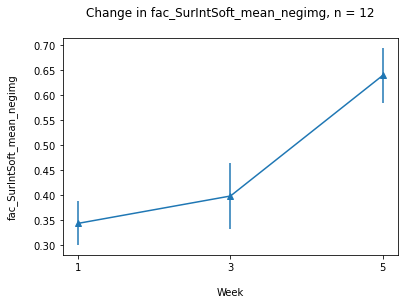

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.623045,2,0.311523,26.108252,3.985843e-07,4.658781e-07,0.650945,0.986869,True,0.986694,0.935217
1,Error,0.334095,28,0.011932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.347,0.402,-0.054,0.078,two-sided,-0.691,0.750,-0.250
1,1,3,0.347,0.640,-0.292,0.082,two-sided,-3.584,0.001,-1.346
2,2,3,0.402,0.640,-0.238,0.083,two-sided,-2.876,0.012,-1.096


fac_SurIntSoft_mean_neuimg, n = 12


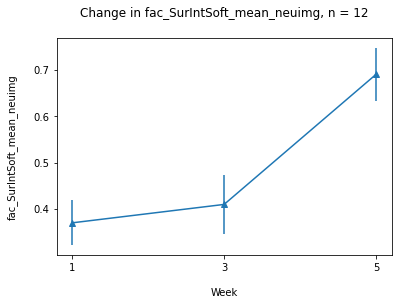

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.757609,2,0.378805,22.286476,0.000002,0.000002,0.614181,0.986072,True,0.985875,0.931342
1,Error,0.475918,28,0.016997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.379,0.409,-0.030,0.077,two-sided,-0.394,0.900,-0.142
1,1,3,0.379,0.691,-0.312,0.080,two-sided,-3.898,0.001,-1.464
2,2,3,0.409,0.691,-0.282,0.081,two-sided,-3.465,0.002,-1.320


fac_SurIntSoft_mean_posimg, n = 12


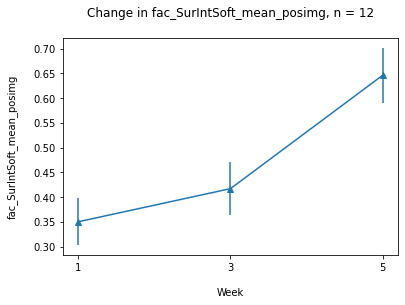

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.593554,2,0.296777,17.314162,0.000013,0.000017,0.552918,0.968233,True,0.96719,0.846369
1,Error,0.479940,28,0.017141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.358,0.420,-0.061,0.069,two-sided,-0.891,0.635,-0.322
1,1,3,0.358,0.646,-0.288,0.072,two-sided,-4.007,0.001,-1.505
2,2,3,0.420,0.646,-0.227,0.073,two-sided,-3.104,0.006,-1.182


fac_SurPres_mean_negimg, n = 12


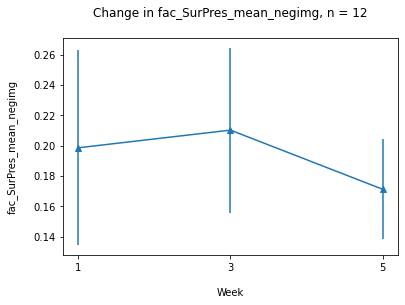

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.006139,2,0.003069,0.163758,0.849755,0.775685,0.011562,0.709612,True,0.590779,0.071966
1,Error,0.524820,28,0.018744,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.176,0.199,-0.023,0.064,two-sided,-0.361,0.9,-0.130
1,1,3,0.176,0.171,0.005,0.067,two-sided,0.075,0.9,0.028
2,2,3,0.199,0.171,0.028,0.068,two-sided,0.415,0.9,0.158


fac_SurPres_mean_neuimg, n = 12


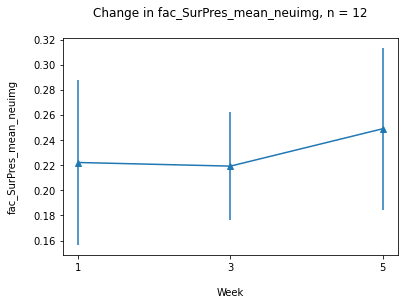

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.005697,2,0.002848,0.143928,0.866587,0.807593,0.010176,0.753429,True,0.672734,0.13779
1,Error,0.554136,28,0.019791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.223,0.224,-0.001,0.073,two-sided,-0.018,0.9,-0.007
1,1,3,0.223,0.249,-0.027,0.076,two-sided,-0.350,0.9,-0.131
2,2,3,0.224,0.249,-0.025,0.077,two-sided,-0.327,0.9,-0.124


fac_SurPres_mean_posimg, n = 12


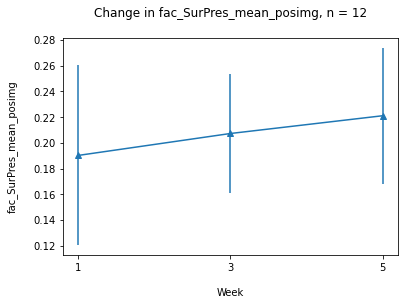

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.008464,2,0.004232,0.200585,0.819418,0.754138,0.014125,0.742195,True,0.652646,0.11841
1,Error,0.590767,28,0.021099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.192,0.188,0.004,0.071,two-sided,0.056,0.900,0.020
1,1,3,0.192,0.221,-0.029,0.074,two-sided,-0.398,0.900,-0.150
2,2,3,0.188,0.221,-0.033,0.075,two-sided,-0.445,0.892,-0.169


mov_HeadVel_mean_negimg, n = 12


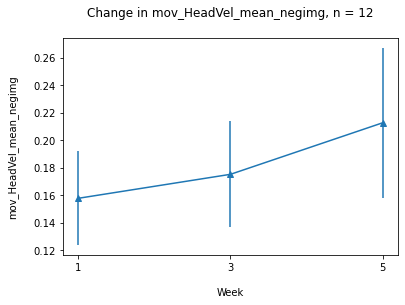

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.034912,2,0.017456,2.485818,0.101448,0.133565,0.150785,0.549943,False,0.181631,0.000198
1,Error,0.196623,28,0.007022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.141,0.166,-0.026,0.053,two-sided,-0.481,0.871,-0.174
1,1,3,0.141,0.213,-0.072,0.055,two-sided,-1.298,0.398,-0.487
2,2,3,0.166,0.213,-0.046,0.056,two-sided,-0.824,0.673,-0.314


mov_HeadVel_mean_neuimg, n = 12


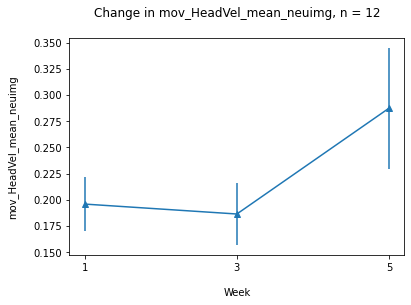

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.090707,2,0.045353,8.897389,0.00102,0.00692,0.388577,0.577588,False,0.268663,0.0014
1,Error,0.142726,28,0.005097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.188,0.180,0.008,0.049,two-sided,0.164,0.900,0.059
1,1,3,0.188,0.287,-0.099,0.051,two-sided,-1.950,0.128,-0.732
2,2,3,0.180,0.287,-0.107,0.052,two-sided,-2.074,0.098,-0.790


mov_HeadVel_mean_posimg, n = 12


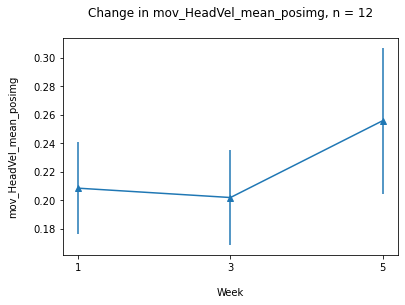

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.033617,2,0.016808,3.578086,0.041323,0.063849,0.203554,0.668752,False,0.504676,0.032739
1,Error,0.131532,28,0.004698,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.203,0.186,0.016,0.049,two-sided,0.333,0.900,0.120
1,1,3,0.203,0.256,-0.053,0.051,two-sided,-1.039,0.549,-0.390
2,2,3,0.186,0.256,-0.070,0.052,two-sided,-1.337,0.377,-0.509


mov_HeadVel_std_negimg, n = 12


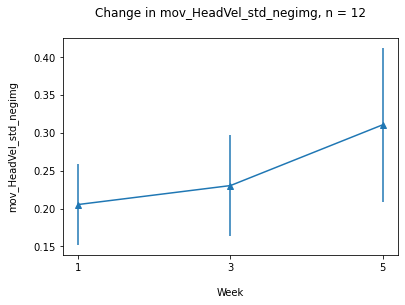

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.101770,2,0.050885,1.596089,0.220583,0.227414,0.102339,0.678259,False,0.525638,0.040127
1,Error,0.892669,28,0.031881,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.191,0.218,-0.028,0.094,two-sided,-0.294,0.900,-0.106
1,1,3,0.191,0.311,-0.120,0.098,two-sided,-1.228,0.439,-0.461
2,2,3,0.218,0.311,-0.092,0.099,two-sided,-0.930,0.612,-0.354


mov_HeadVel_std_neuimg, n = 12


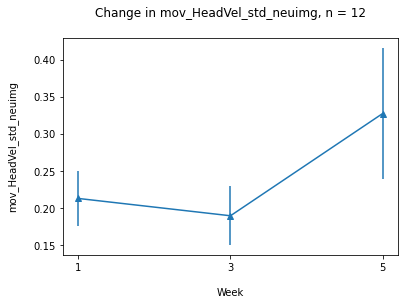

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.126235,2,0.063118,3.688149,0.037865,0.068616,0.20851,0.56963,False,0.244473,0.000873
1,Error,0.479182,28,0.017114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.217,0.196,0.021,0.073,two-sided,0.287,0.900,0.104
1,1,3,0.217,0.328,-0.110,0.076,two-sided,-1.449,0.318,-0.544
2,2,3,0.196,0.328,-0.131,0.077,two-sided,-1.697,0.209,-0.647


mov_HeadVel_std_posimg, n = 12


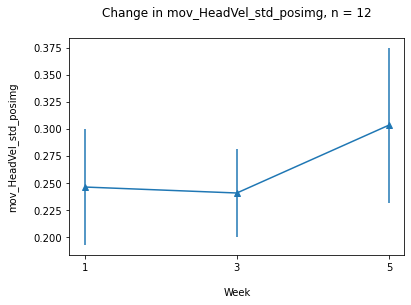

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.039197,2,0.019599,1.533328,0.233394,0.237892,0.098712,0.697364,True,0.566028,0.058102
1,Error,0.357887,28,0.012782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.256,0.226,0.030,0.071,two-sided,0.429,0.900,0.155
1,1,3,0.256,0.304,-0.047,0.074,two-sided,-0.638,0.780,-0.240
2,2,3,0.226,0.304,-0.078,0.075,two-sided,-1.033,0.552,-0.394


mov_HposeDist_mean_negimg, n = 12


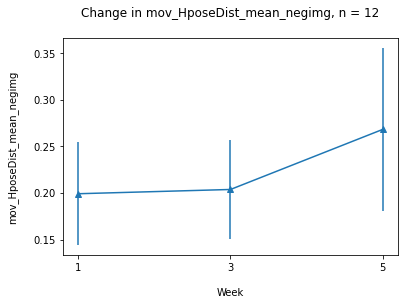

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.065193,2,0.032597,1.405868,0.261931,0.259573,0.091255,0.605382,False,0.34815,0.005115
1,Error,0.649209,28,0.023186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.174,0.189,-0.015,0.082,two-sided,-0.183,0.900,-0.066
1,1,3,0.174,0.268,-0.094,0.085,two-sided,-1.098,0.515,-0.412
2,2,3,0.189,0.268,-0.079,0.087,two-sided,-0.908,0.625,-0.346


mov_HposeDist_mean_neuimg, n = 12


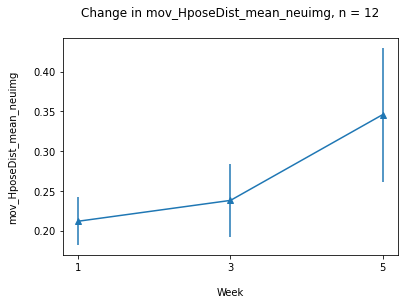

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.147155,2,0.073578,5.012939,0.013775,0.032507,0.263659,0.613876,False,0.371006,0.007029
1,Error,0.410970,28,0.014678,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.204,0.230,-0.025,0.070,two-sided,-0.363,0.900,-0.131
1,1,3,0.204,0.346,-0.142,0.073,two-sided,-1.949,0.128,-0.732
2,2,3,0.230,0.346,-0.116,0.074,two-sided,-1.576,0.258,-0.600


mov_HposeDist_mean_posimg, n = 12


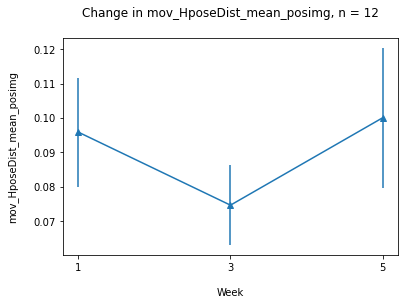

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.006570,2,0.003285,3.177265,0.057074,0.083538,0.184969,0.639697,True,1453.300855,1.0
1,Error,0.028951,28,0.001034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.089,0.069,0.020,0.020,two-sided,0.976,0.586,0.352
1,1,3,0.089,0.100,-0.012,0.021,two-sided,-0.546,0.833,-0.205
2,2,3,0.069,0.100,-0.031,0.021,two-sided,-1.459,0.313,-0.556


mov_HposeDist_std_negimg, n = 12


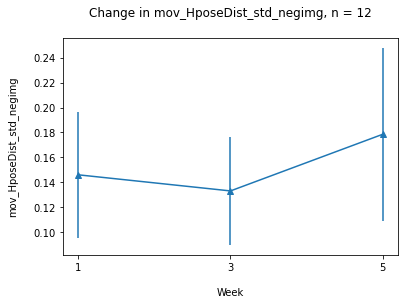

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.023391,2,0.011696,0.51541,0.602813,0.567856,0.035508,0.817173,True,0.776269,0.281878
1,Error,0.635380,28,0.022692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.135,0.120,0.014,0.068,two-sided,0.211,0.900,0.076
1,1,3,0.135,0.179,-0.044,0.071,two-sided,-0.621,0.790,-0.233
2,2,3,0.120,0.179,-0.058,0.072,two-sided,-0.810,0.681,-0.309


mov_HposeDist_std_neuimg, n = 12


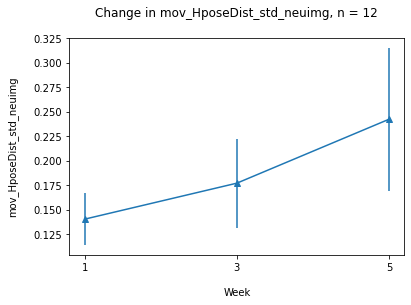

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.063106,2,0.031553,2.71557,0.083579,0.106099,0.162458,0.68934,True,0.549338,0.050026
1,Error,0.325339,28,0.011619,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.145,0.188,-0.043,0.065,two-sided,-0.657,0.769,-0.237
1,1,3,0.145,0.242,-0.097,0.068,two-sided,-1.430,0.327,-0.537
2,2,3,0.188,0.242,-0.054,0.069,two-sided,-0.788,0.694,-0.300


mov_HposeDist_std_posimg, n = 12


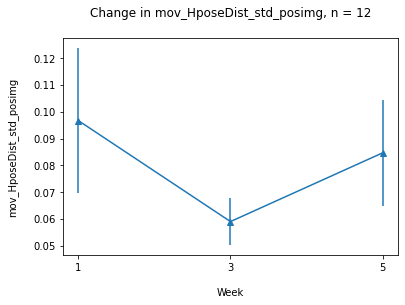

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.009093,2,0.004546,1.422651,0.257968,0.256998,0.092244,0.623739,True,530.852906,1.0
1,Error,0.089479,28,0.003196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.088,0.055,0.033,0.025,two-sided,1.330,0.381,0.480
1,1,3,0.088,0.085,0.003,0.026,two-sided,0.118,0.900,0.044
2,2,3,0.055,0.085,-0.030,0.026,two-sided,-1.140,0.491,-0.434


mov_HposePitch_mean_negimg, n = 12


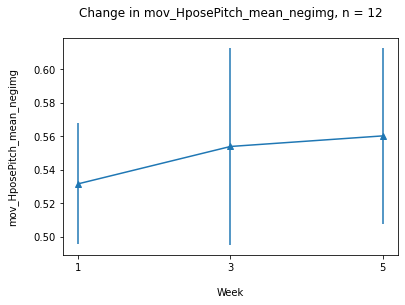

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.002282,2,0.001141,0.166806,0.847199,0.762226,0.011774,0.677559,False,0.524114,0.039548
1,Error,0.191568,28,0.006842,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.545,0.543,0.002,0.062,two-sided,0.031,0.9,0.011
1,1,3,0.545,0.560,-0.015,0.065,two-sided,-0.238,0.9,-0.089
2,2,3,0.543,0.560,-0.017,0.066,two-sided,-0.263,0.9,-0.100


mov_HposePitch_mean_neuimg, n = 12


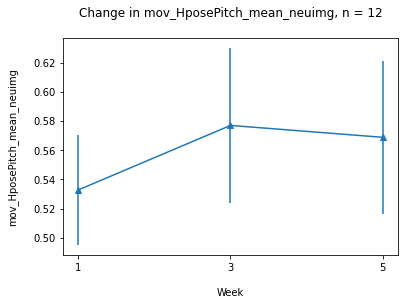

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.011978,2,0.005989,1.569239,0.225969,0.231976,0.100791,0.656157,False,0.475974,0.02443
1,Error,0.106864,28,0.003817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.534,0.571,-0.036,0.061,two-sided,-0.596,0.805,-0.215
1,1,3,0.534,0.569,-0.034,0.064,two-sided,-0.539,0.837,-0.203
2,2,3,0.571,0.569,0.002,0.065,two-sided,0.032,0.900,0.012


mov_HposePitch_mean_posimg, n = 12


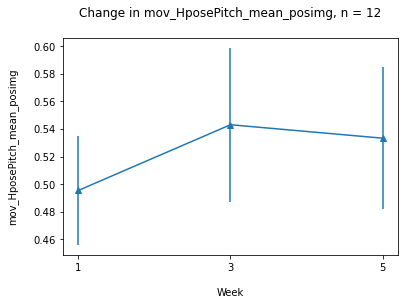

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.007955,2,0.003978,0.640258,0.5347,0.507008,0.043733,0.823289,True,0.78536,0.298775
1,Error,0.173955,28,0.006213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.506,0.535,-0.030,0.061,two-sided,-0.491,0.865,-0.177
1,1,3,0.506,0.533,-0.028,0.063,two-sided,-0.439,0.895,-0.165
2,2,3,0.535,0.533,0.002,0.064,two-sided,0.031,0.900,0.012


mov_HposePitch_std_negimg, n = 12


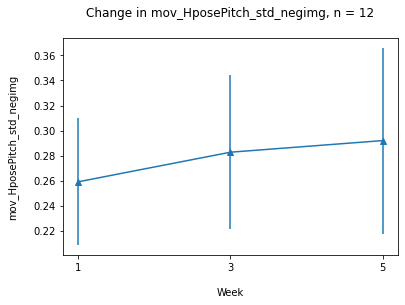

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.022522,2,0.011261,0.432804,0.652954,0.612179,0.029988,0.808676,True,0.76341,0.259293
1,Error,0.728509,28,0.026018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.235,0.269,-0.034,0.077,two-sided,-0.443,0.893,-0.160
1,1,3,0.235,0.292,-0.057,0.080,two-sided,-0.711,0.738,-0.267
2,2,3,0.269,0.292,-0.023,0.082,two-sided,-0.282,0.900,-0.107


mov_HposePitch_std_neuimg, n = 12


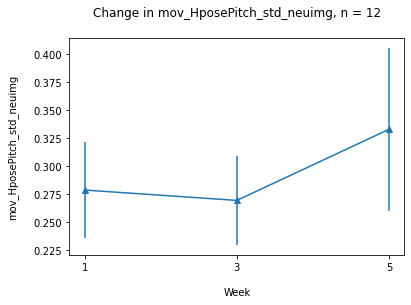

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.025793,2,0.012897,1.47022,0.247082,0.249331,0.095035,0.719805,True,0.610735,0.08497
1,Error,0.245615,28,0.008772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.286,0.272,0.014,0.067,two-sided,0.214,0.900,0.077
1,1,3,0.286,0.333,-0.047,0.070,two-sided,-0.670,0.762,-0.252
2,2,3,0.272,0.333,-0.061,0.071,two-sided,-0.862,0.651,-0.328


mov_HposePitch_std_posimg, n = 12


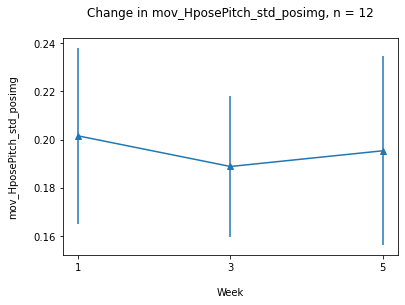

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.002591,2,0.001296,0.162328,0.850957,0.82929,0.011462,0.899465,True,0.888228,0.55287
1,Error,0.223503,28,0.007982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.183,0.175,0.008,0.044,two-sided,0.178,0.9,0.064
1,1,3,0.183,0.195,-0.012,0.046,two-sided,-0.266,0.9,-0.100
2,2,3,0.175,0.195,-0.020,0.046,two-sided,-0.430,0.9,-0.164


mov_HposeRoll_mean_negimg, n = 12


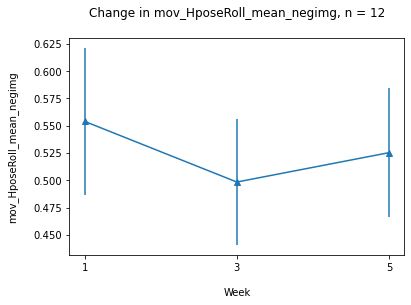

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.006957,2,0.003479,0.710358,0.500112,0.488456,0.04829,0.911118,True,0.902447,0.598563
1,Error,0.137116,28,0.004897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.515,0.493,0.021,0.082,two-sided,0.258,0.9,0.093
1,1,3,0.515,0.525,-0.011,0.085,two-sided,-0.126,0.9,-0.047
2,2,3,0.493,0.525,-0.032,0.087,two-sided,-0.367,0.9,-0.140


mov_HposeRoll_mean_neuimg, n = 12


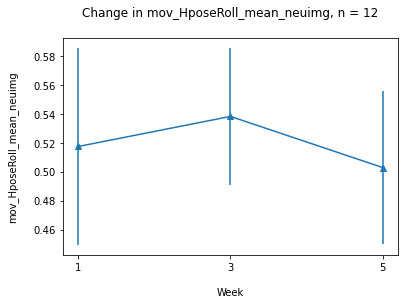

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.020472,2,0.010236,5.165977,0.012313,0.017318,0.269539,0.852189,True,0.826552,0.38579
1,Error,0.055481,28,0.001981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.496,0.546,-0.050,0.073,two-sided,-0.686,0.753,-0.248
1,1,3,0.496,0.503,-0.007,0.076,two-sided,-0.089,0.900,-0.033
2,2,3,0.546,0.503,0.043,0.077,two-sided,0.560,0.825,0.213


mov_HposeRoll_mean_posimg, n = 12


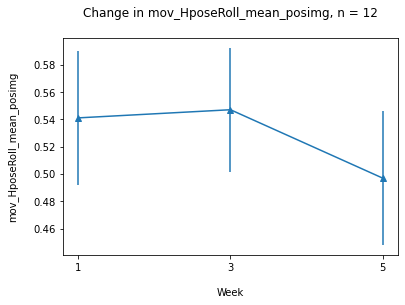

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.017787,2,0.008893,-3.612115,1.0,1.0,-0.347724,0.820783,True,0.781651,0.291786
1,Error,-0.068940,28,-0.002462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.518,0.549,-0.031,0.063,two-sided,-0.493,0.864,-0.178
1,1,3,0.518,0.497,0.021,0.065,two-sided,0.322,0.900,0.121
2,2,3,0.549,0.497,0.052,0.066,two-sided,0.783,0.697,0.298


mov_HposeRoll_std_negimg, n = 12


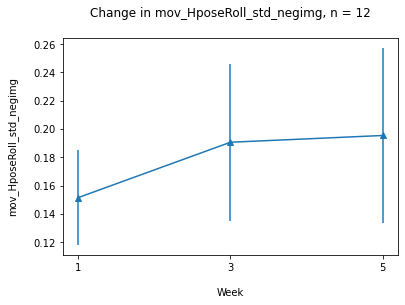

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.021237,2,0.010618,0.538572,0.589506,0.561224,0.037044,0.844801,True,0.81629,0.362428
1,Error,0.552044,28,0.019716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.148,0.195,-0.047,0.063,two-sided,-0.746,0.718,-0.269
1,1,3,0.148,0.195,-0.048,0.066,two-sided,-0.726,0.730,-0.273
2,2,3,0.195,0.195,-0.001,0.067,two-sided,-0.010,0.900,-0.004


mov_HposeRoll_std_neuimg, n = 12


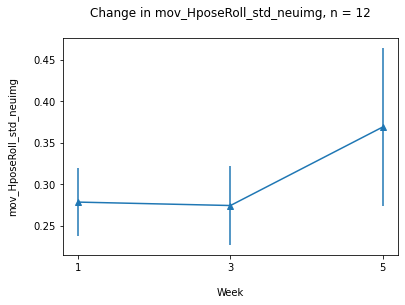

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.043315,2,0.021657,1.0248,0.371938,0.34264,0.068207,0.613246,False,0.369333,0.006872
1,Error,0.591733,28,0.021133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.299,0.296,0.004,0.083,two-sided,0.044,0.900,0.016
1,1,3,0.299,0.369,-0.070,0.086,two-sided,-0.807,0.683,-0.303
2,2,3,0.296,0.369,-0.073,0.088,two-sided,-0.836,0.666,-0.319


mov_HposeRoll_std_posimg, n = 12


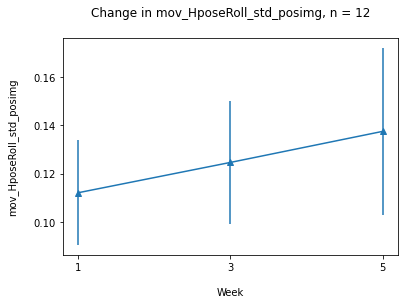

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.004275,2,0.002137,0.469688,0.630034,0.563896,0.03246,0.696957,True,0.565191,0.057673
1,Error,0.127420,28,0.004551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.113,0.130,-0.017,0.034,two-sided,-0.493,0.864,-0.178
1,1,3,0.113,0.138,-0.024,0.036,two-sided,-0.683,0.754,-0.257
2,2,3,0.130,0.138,-0.007,0.036,two-sided,-0.207,0.900,-0.079


mov_HposeYaw_mean_negimg, n = 12


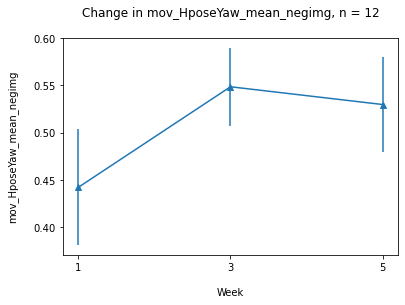

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.039713,2,0.019857,2.556365,0.095561,0.109805,0.154404,0.793956,True,0.740484,0.222627
1,Error,0.217491,28,0.007768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.486,0.559,-0.073,0.067,two-sided,-1.099,0.514,-0.397
1,1,3,0.486,0.530,-0.044,0.070,two-sided,-0.634,0.783,-0.238
2,2,3,0.559,0.530,0.029,0.071,two-sided,0.414,0.900,0.158


mov_HposeYaw_mean_neuimg, n = 12


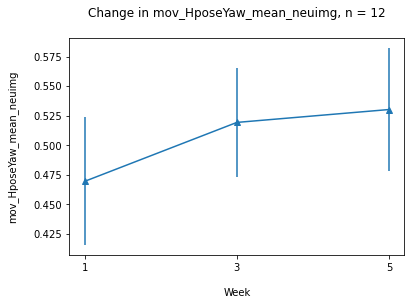

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.009174,2,0.004587,1.400436,0.263227,0.263372,0.090935,0.978734,True,0.978272,0.89598
1,Error,0.091711,28,0.003275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.493,0.51,-0.017,0.067,two-sided,-0.257,0.900,-0.093
1,1,3,0.493,0.53,-0.037,0.070,two-sided,-0.532,0.841,-0.200
2,2,3,0.510,0.53,-0.020,0.071,two-sided,-0.281,0.900,-0.107


mov_HposeYaw_mean_posimg, n = 12


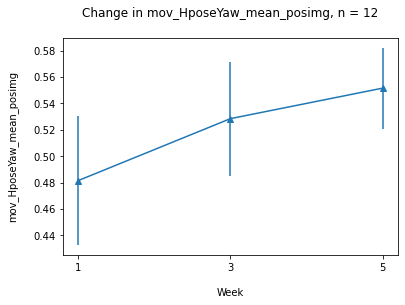

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.012690,2,0.006345,2.256183,0.123462,0.131246,0.138789,0.876702,True,0.859362,0.468684
1,Error,0.078741,28,0.002812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.508,0.532,-0.024,0.056,two-sided,-0.423,0.90,-0.153
1,1,3,0.508,0.552,-0.043,0.058,two-sided,-0.742,0.72,-0.279
2,2,3,0.532,0.552,-0.020,0.059,two-sided,-0.331,0.90,-0.126


mov_HposeYaw_std_negimg, n = 12


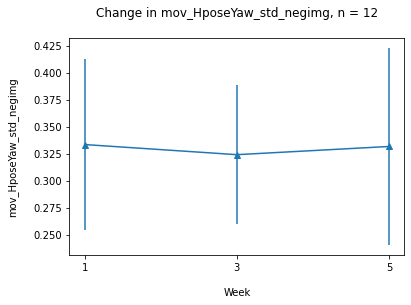

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.004318,2,0.002159,0.071923,0.930774,0.913181,0.005111,0.891975,True,0.878892,0.524418
1,Error,0.840464,28,0.030017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.309,0.310,-0.001,0.098,two-sided,-0.011,0.9,-0.004
1,1,3,0.309,0.332,-0.023,0.102,two-sided,-0.226,0.9,-0.085
2,2,3,0.310,0.332,-0.022,0.103,two-sided,-0.212,0.9,-0.081


mov_HposeYaw_std_neuimg, n = 12


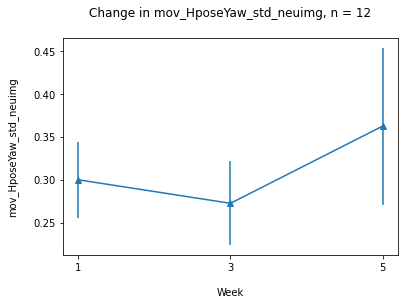

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.040023,2,0.020011,1.382281,0.26761,0.264791,0.089862,0.63625,False,0.428291,0.014411
1,Error,0.405360,28,0.014477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.304,0.287,0.017,0.083,two-sided,0.204,0.900,0.074
1,1,3,0.304,0.363,-0.059,0.087,two-sided,-0.678,0.757,-0.254
2,2,3,0.287,0.363,-0.076,0.088,two-sided,-0.860,0.653,-0.327


mov_HposeYaw_std_posimg, n = 12


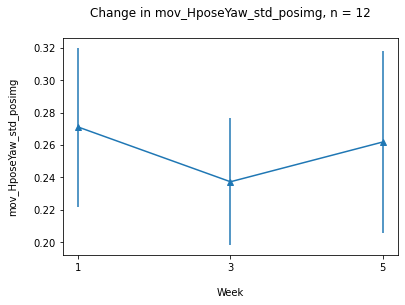

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.006882,2,0.003441,0.307642,0.737632,0.680244,0.021502,0.764966,True,0.692753,0.159548
1,Error,0.313189,28,0.011185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.246,0.229,0.017,0.060,two-sided,0.278,0.900,0.101
1,1,3,0.246,0.262,-0.016,0.063,two-sided,-0.254,0.900,-0.095
2,2,3,0.229,0.262,-0.033,0.064,two-sided,-0.513,0.852,-0.195


nlp_sentiment_mean_mean_negimg, n = 11


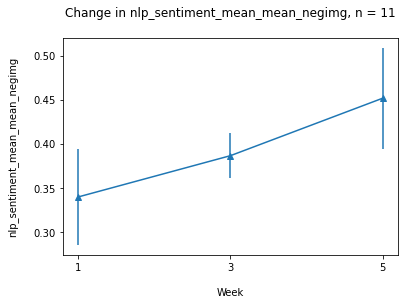

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.064792,2,0.032396,2.235129,0.127135,0.146508,0.146709,0.698195,True,0.567736,0.078281
1,Error,0.376844,26,0.014494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.350,0.404,-0.054,0.062,two-sided,-0.885,0.638,-0.330
1,1,3,0.350,0.452,-0.102,0.064,two-sided,-1.583,0.255,-0.617
2,2,3,0.404,0.452,-0.047,0.065,two-sided,-0.725,0.730,-0.287


nlp_sentiment_mean_mean_neuimg, n = 11


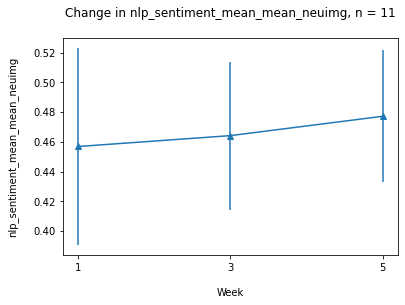

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.007667,2,0.003834,0.289655,0.750906,0.694263,0.021796,0.768896,True,0.699434,0.200152
1,Error,0.344117,26,0.013235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.442,0.457,-0.015,0.073,two-sided,-0.212,0.900,-0.079
1,1,3,0.442,0.477,-0.035,0.076,two-sided,-0.464,0.881,-0.181
2,2,3,0.457,0.477,-0.020,0.077,two-sided,-0.257,0.900,-0.102


nlp_sentiment_mean_mean_posimg, n = 11


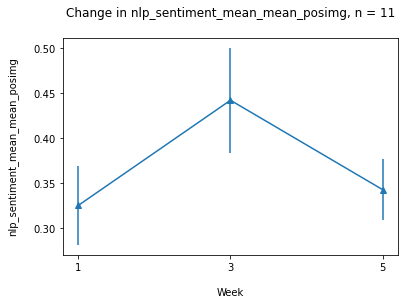

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.057055,2,0.028528,1.649228,0.211676,0.2131,0.112581,0.956419,True,0.954433,0.81069
1,Error,0.449737,26,0.017298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.325,0.413,-0.088,0.058,two-sided,-1.510,0.288,-0.564
1,1,3,0.325,0.343,-0.019,0.061,two-sided,-0.304,0.900,-0.118
2,2,3,0.413,0.343,0.070,0.062,two-sided,1.121,0.502,0.444


nlp_sentiment_range_mean_negimg, n = 10


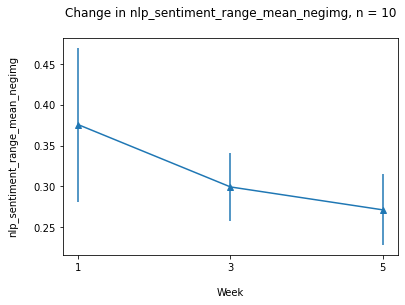

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.050006,2,0.025003,0.969327,0.3937,0.351203,0.07474,0.546584,False,0.170454,0.000844
1,Error,0.619057,24,0.025794,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.354,0.312,0.042,0.076,two-sided,0.551,0.831,0.213
1,1,3,0.354,0.261,0.093,0.079,two-sided,1.178,0.468,0.474
2,2,3,0.312,0.261,0.051,0.078,two-sided,0.661,0.767,0.262


nlp_sentiment_range_mean_neuimg, n = 11


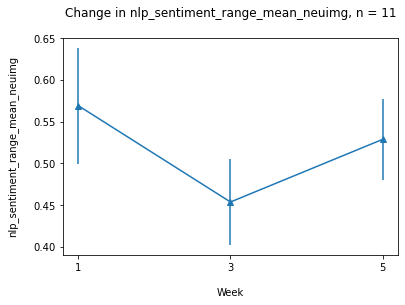

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.084172,2,0.042086,3.26886,0.054153,0.060765,0.200927,0.896198,True,0.884175,0.574676
1,Error,0.334746,26,0.012875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.508,0.420,0.088,0.080,two-sided,1.112,0.507,0.415
1,1,3,0.508,0.529,-0.021,0.083,two-sided,-0.252,0.900,-0.098
2,2,3,0.420,0.529,-0.109,0.085,two-sided,-1.293,0.402,-0.511


nlp_sentiment_range_mean_posimg, n = 8


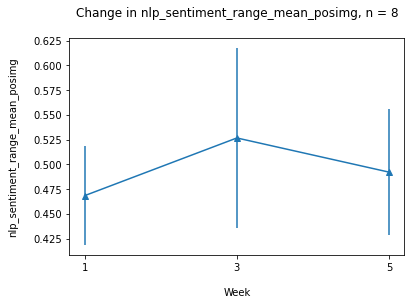

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.002415,2,0.001208,0.215482,0.807696,0.792564,0.01764,0.93098,True,0.925863,0.793671
1,Error,0.134510,24,0.005605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.410,0.429,-0.019,0.090,two-sided,-0.207,0.9,-0.082
1,1,3,0.410,0.412,-0.002,0.090,two-sided,-0.020,0.9,-0.008
2,2,3,0.429,0.412,0.017,0.094,two-sided,0.179,0.9,0.074


nlp_sentiment_stdev_mean_negimg, n = 10


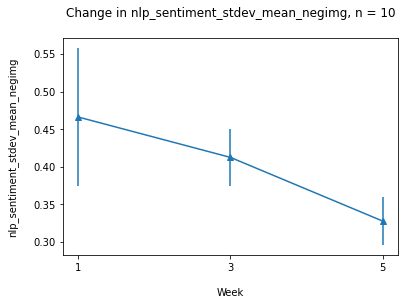

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.114095,2,0.057048,1.923545,0.167949,0.189887,0.138151,0.527026,False,0.102559,0.000111
1,Error,0.711780,24,0.029658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.446,0.432,0.014,0.073,two-sided,0.195,0.900,0.076
1,1,3,0.446,0.317,0.129,0.076,two-sided,1.700,0.208,0.684
2,2,3,0.432,0.317,0.115,0.074,two-sided,1.541,0.274,0.610


nlp_sentiment_stdev_mean_neuimg, n = 11


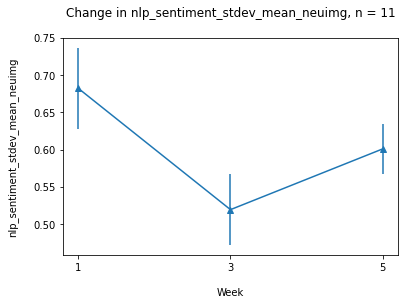

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.144346,2,0.072173,6.67562,0.004573,0.004626,0.339284,0.996328,True,0.996315,0.983523
1,Error,0.281097,26,0.010811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.621,0.483,0.137,0.072,two-sided,1.922,0.135,0.718
1,1,3,0.621,0.601,0.020,0.075,two-sided,0.262,0.900,0.102
2,2,3,0.483,0.601,-0.118,0.076,two-sided,-1.550,0.270,-0.613


nlp_sentiment_stdev_mean_posimg, n = 8


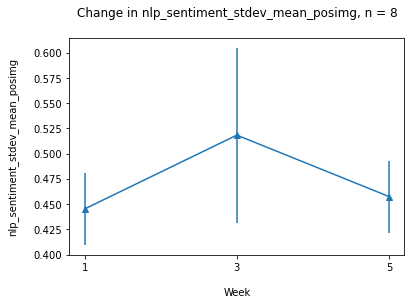

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.004783,2,0.002391,0.339284,0.715641,0.642209,0.027496,0.703311,True,0.578155,0.193256
1,Error,0.169156,24,0.007048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.404,0.421,-0.017,0.078,two-sided,-0.221,0.9,-0.087
1,1,3,0.404,0.392,0.012,0.078,two-sided,0.156,0.9,0.062
2,2,3,0.421,0.392,0.029,0.081,two-sided,0.362,0.9,0.149


aco_HRF_mean, n = 12


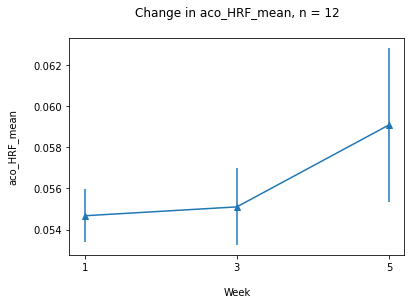

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.035221,2,0.017610,2.385385,0.110509,0.13633,0.14558,0.622901,True,inf,1.0
1,Error,0.206713,28,0.007383,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.118,0.055,0.062,0.055,two-sided,1.134,0.495,0.409
1,1,3,0.118,0.059,0.059,0.057,two-sided,1.023,0.559,0.384
2,2,3,0.055,0.059,-0.004,0.058,two-sided,-0.064,0.900,-0.024


aco_QOQ_mean, n = 12


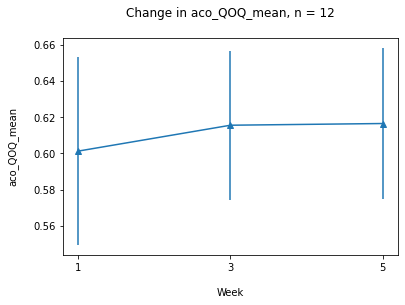

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.000841,2,0.000420,0.142022,0.868223,0.812018,0.010043,0.762384,True,0.688326,0.154515
1,Error,0.082900,28,0.002961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.608,0.618,-0.010,0.057,two-sided,-0.176,0.9,-0.064
1,1,3,0.608,0.616,-0.009,0.059,two-sided,-0.145,0.9,-0.055
2,2,3,0.618,0.616,0.001,0.060,two-sided,0.024,0.9,0.009


aco_voicePct_mean, n = 12


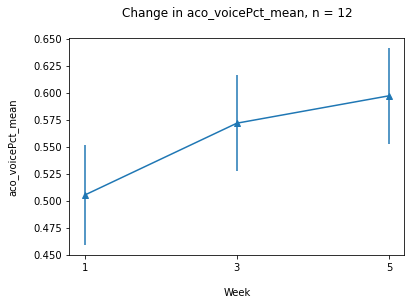

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.043391,2,0.021695,2.749366,0.081248,0.090095,0.164147,0.870096,True,0.850701,0.445539
1,Error,0.220949,28,0.007891,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.521,0.576,-0.055,0.055,two-sided,-0.998,0.573,-0.36
1,1,3,0.521,0.597,-0.077,0.058,two-sided,-1.331,0.380,-0.50
2,2,3,0.576,0.597,-0.022,0.059,two-sided,-0.368,0.900,-0.14


fac_AngIntHard_mean, n = 13


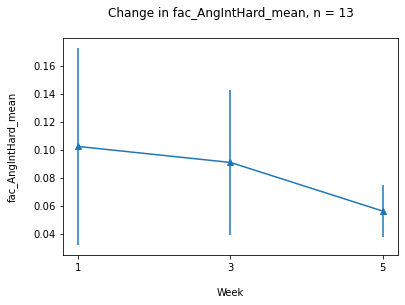

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.008818,2,0.004409,0.20377,0.816849,0.738954,0.014346,0.702709,False,0.576936,0.048551
1,Error,0.605833,28,0.021637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.091,0.080,0.011,0.065,two-sided,0.171,0.900,0.061
1,1,3,0.091,0.056,0.035,0.068,two-sided,0.519,0.849,0.191
2,2,3,0.080,0.056,0.024,0.068,two-sided,0.354,0.900,0.130


fac_AngIntSoft_mean, n = 13


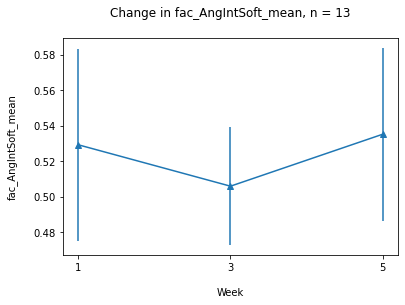

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.002388,2,0.001194,0.090925,0.913355,0.906809,0.006453,0.96093,True,0.959341,0.795887
1,Error,0.367761,28,0.013134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.518,0.531,-0.013,0.065,two-sided,-0.203,0.9,-0.072
1,1,3,0.518,0.535,-0.017,0.068,two-sided,-0.258,0.9,-0.095
2,2,3,0.531,0.535,-0.004,0.068,two-sided,-0.062,0.9,-0.023


fac_AngPres_mean, n = 13


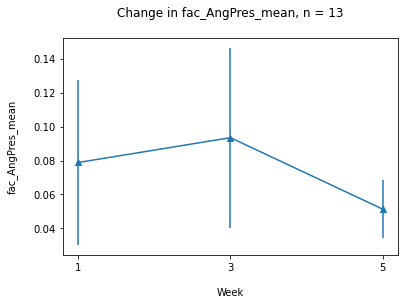

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.007113,2,0.003556,0.255981,0.775949,0.728021,0.017956,0.802483,True,0.753867,0.211408
1,Error,0.389001,28,0.013893,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.071,0.083,-0.012,0.054,two-sided,-0.219,0.900,-0.078
1,1,3,0.071,0.051,0.020,0.056,two-sided,0.356,0.900,0.131
2,2,3,0.083,0.051,0.032,0.056,two-sided,0.567,0.821,0.209


fac_ComIntHard_mean, n = 13


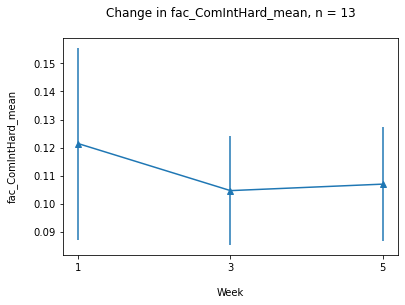

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.001084,2,0.000542,0.249517,0.780891,0.662789,0.017511,0.588959,True,840.575028,1.0
1,Error,0.060831,28,0.002173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.117,0.106,0.011,0.032,two-sided,0.342,0.9,0.122
1,1,3,0.117,0.107,0.010,0.034,two-sided,0.290,0.9,0.107
2,2,3,0.106,0.107,-0.001,0.034,two-sided,-0.040,0.9,-0.015


fac_ComIntSoft_mean, n = 13


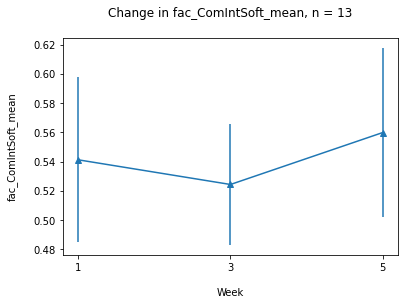

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.003551,2,0.001776,0.196582,0.822658,0.764816,0.013847,0.766546,True,0.695447,0.13566
1,Error,0.252908,28,0.009032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.538,0.542,-0.004,0.067,two-sided,-0.060,0.9,-0.021
1,1,3,0.538,0.560,-0.021,0.070,two-sided,-0.308,0.9,-0.113
2,2,3,0.542,0.560,-0.017,0.070,two-sided,-0.250,0.9,-0.092


fac_ConIntHard_mean, n = 13


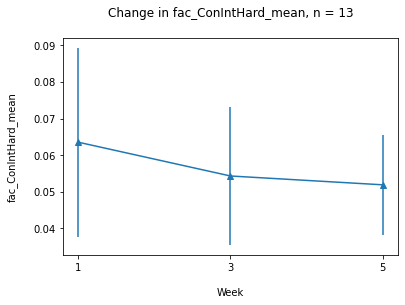

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.000444,2,0.000222,0.125243,0.882774,0.829962,0.008867,0.768557,True,1288.00864,1.0
1,Error,0.049641,28,0.001773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.060,0.057,0.002,0.025,two-sided,0.089,0.9,0.032
1,1,3,0.060,0.052,0.008,0.026,two-sided,0.297,0.9,0.109
2,2,3,0.057,0.052,0.006,0.026,two-sided,0.211,0.9,0.078


fac_ConIntSoft_mean, n = 13


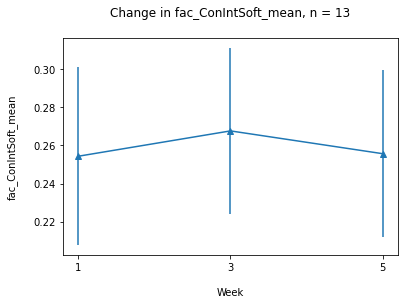

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.001340,2,0.000670,0.124693,0.883256,0.863453,0.008828,0.90114,True,0.890295,0.527759
1,Error,0.150415,28,0.005372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.254,0.266,-0.013,0.056,two-sided,-0.224,0.9,-0.080
1,1,3,0.254,0.256,-0.002,0.058,two-sided,-0.036,0.9,-0.013
2,2,3,0.266,0.256,0.010,0.058,two-sided,0.180,0.9,0.066


fac_ConPres_mean, n = 13


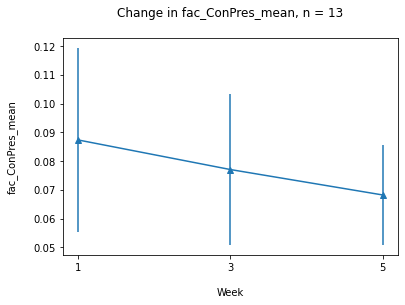

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.002156,2,0.001078,0.416037,0.663667,0.589154,0.028859,0.682629,True,778.745932,1.0
1,Error,0.072540,28,0.002591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.086,0.080,0.006,0.033,two-sided,0.173,0.900,0.061
1,1,3,0.086,0.068,0.017,0.034,two-sided,0.511,0.853,0.188
2,2,3,0.080,0.068,0.012,0.034,two-sided,0.345,0.900,0.127


fac_DisIntHard_mean, n = 13


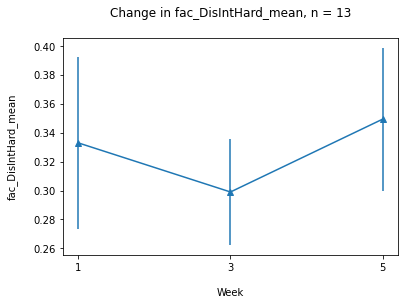

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.000260,2,0.000130,0.009123,0.990922,0.975965,0.000651,0.764808,True,0.692482,0.13251
1,Error,0.399332,28,0.014262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.348,0.344,0.005,0.071,two-sided,0.063,0.9,0.023
1,1,3,0.348,0.349,-0.001,0.074,two-sided,-0.016,0.9,-0.006
2,2,3,0.344,0.349,-0.006,0.074,two-sided,-0.077,0.9,-0.028


fac_DisIntSoft_mean, n = 13


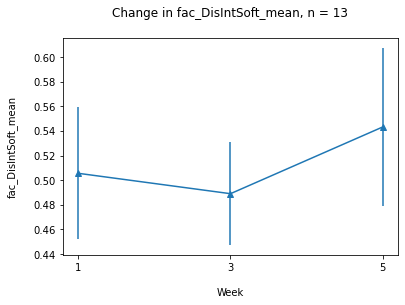

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.011543,2,0.005772,0.605063,0.553024,0.520294,0.041428,0.805212,True,0.758091,0.218005
1,Error,0.267087,28,0.009539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.536,0.505,0.030,0.075,two-sided,0.407,0.900,0.145
1,1,3,0.536,0.543,-0.007,0.077,two-sided,-0.096,0.900,-0.035
2,2,3,0.505,0.543,-0.038,0.077,two-sided,-0.488,0.866,-0.180


fac_DisPres_mean, n = 13


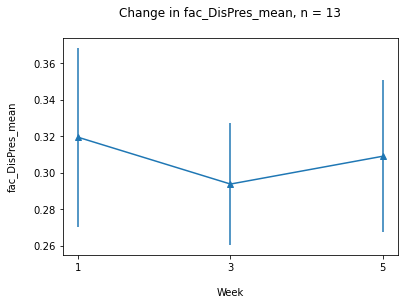

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.005791,2,0.002896,0.318467,0.729862,0.684671,0.022242,0.808309,True,0.762849,0.225638
1,Error,0.254586,28,0.009092,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.335,0.334,0.001,0.062,two-sided,0.014,0.9,0.005
1,1,3,0.335,0.309,0.026,0.064,two-sided,0.400,0.9,0.147
2,2,3,0.334,0.309,0.025,0.064,two-sided,0.386,0.9,0.142


fac_FeaIntHard_mean, n = 13


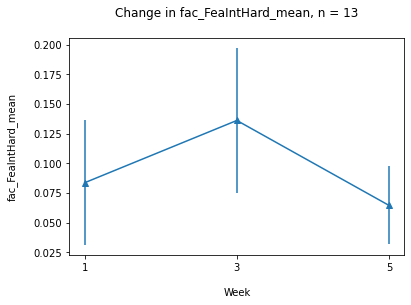

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.024093,2,0.012047,0.652568,0.528445,0.469966,0.044536,0.656132,False,0.475917,0.016843
1,Error,0.516888,28,0.018460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.076,0.119,-0.043,0.064,two-sided,-0.676,0.758,-0.240
1,1,3,0.076,0.064,0.012,0.066,two-sided,0.179,0.900,0.066
2,2,3,0.119,0.064,0.055,0.066,two-sided,0.830,0.670,0.305


fac_FeaIntSoft_mean, n = 13


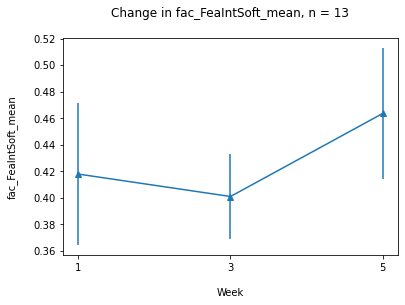

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.016653,2,0.008326,0.588122,0.562084,0.54328,0.040315,0.886234,True,0.871629,0.469705
1,Error,0.396409,28,0.014157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.415,0.438,-0.023,0.067,two-sided,-0.346,0.900,-0.123
1,1,3,0.415,0.464,-0.049,0.070,two-sided,-0.703,0.743,-0.259
2,2,3,0.438,0.464,-0.026,0.070,two-sided,-0.369,0.900,-0.136


fac_FeaPres_mean, n = 13


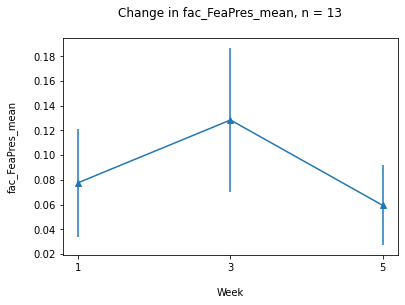

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.023085,2,0.011543,0.812464,0.453952,0.4182,0.05485,0.703091,False,0.577709,0.04891
1,Error,0.397797,28,0.014207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.074,0.114,-0.041,0.058,two-sided,-0.696,0.747,-0.247
1,1,3,0.074,0.059,0.014,0.060,two-sided,0.234,0.900,0.086
2,2,3,0.114,0.059,0.055,0.060,two-sided,0.905,0.626,0.333


fac_HapIntHard_mean, n = 13


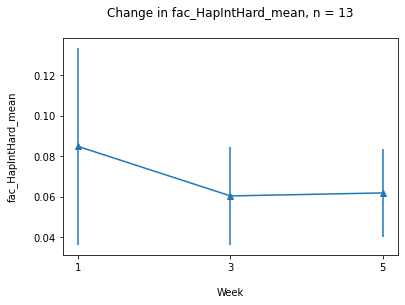

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.005109,2,0.002555,0.813897,0.453338,0.3882,0.054941,0.529194,True,549.763169,1.0
1,Error,0.087888,28,0.003139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.080,0.055,0.025,0.042,two-sided,0.599,0.803,0.213
1,1,3,0.080,0.062,0.018,0.044,two-sided,0.412,0.900,0.152
2,2,3,0.055,0.062,-0.007,0.044,two-sided,-0.165,0.900,-0.061


fac_HapIntSoft_mean, n = 13


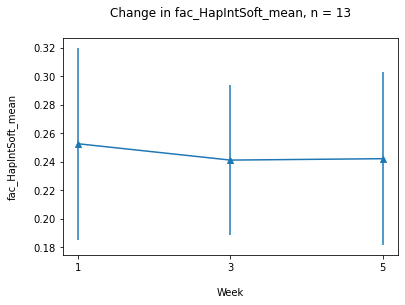

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.002338,2,0.001169,0.24153,0.787045,0.763943,0.01696,0.898254,True,0.886729,0.516239
1,Error,0.135533,28,0.004840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.239,0.225,0.014,0.077,two-sided,0.178,0.9,0.063
1,1,3,0.239,0.242,-0.003,0.080,two-sided,-0.041,0.9,-0.015
2,2,3,0.225,0.242,-0.017,0.080,two-sided,-0.213,0.9,-0.078


fac_HapPres_mean, n = 13


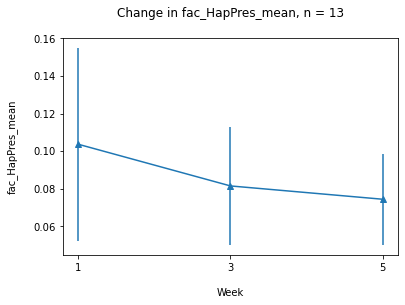

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.006510,2,0.003255,1.031051,0.369778,0.336769,0.068595,0.575086,True,576.202485,1.0
1,Error,0.088392,28,0.003157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.100,0.074,0.026,0.047,two-sided,0.549,0.831,0.195
1,1,3,0.100,0.074,0.026,0.049,two-sided,0.521,0.848,0.192
2,2,3,0.074,0.074,-0.000,0.049,two-sided,-0.008,0.900,-0.003


fac_NegIntHard_mean, n = 13


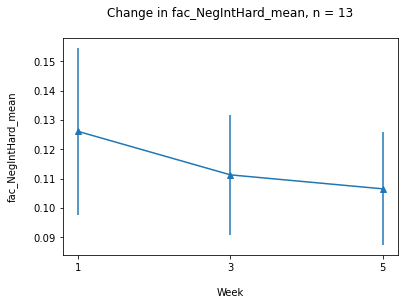

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.001461,2,0.000731,0.283993,0.754915,0.717926,0.019882,0.842216,True,0.812656,0.319512
1,Error,0.072043,28,0.002573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.121,0.117,0.004,0.029,two-sided,0.120,0.900,0.043
1,1,3,0.121,0.107,0.014,0.031,two-sided,0.460,0.883,0.169
2,2,3,0.117,0.107,0.011,0.031,two-sided,0.344,0.900,0.126


fac_NegIntSoft_mean, n = 13


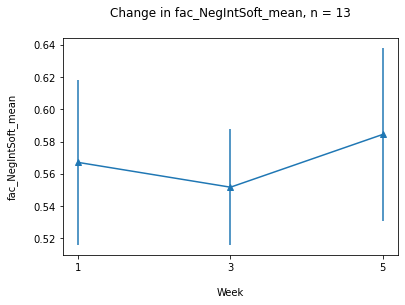

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.002747,2,0.001373,0.14013,0.869851,0.813931,0.00991,0.762804,True,0.689047,0.128934
1,Error,0.274409,28,0.009800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.568,0.584,-0.017,0.065,two-sided,-0.259,0.9,-0.092
1,1,3,0.568,0.584,-0.017,0.067,two-sided,-0.250,0.9,-0.092
2,2,3,0.584,0.584,0.000,0.067,two-sided,0.000,0.9,0.000


fac_PosIntHard_mean, n = 13


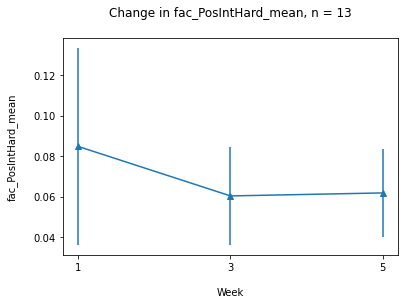

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.005109,2,0.002555,0.813897,0.453338,0.3882,0.054941,0.529194,True,549.763169,1.0
1,Error,0.087888,28,0.003139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.080,0.055,0.025,0.042,two-sided,0.599,0.803,0.213
1,1,3,0.080,0.062,0.018,0.044,two-sided,0.412,0.900,0.152
2,2,3,0.055,0.062,-0.007,0.044,two-sided,-0.165,0.900,-0.061


fac_PosIntSoft_mean, n = 13


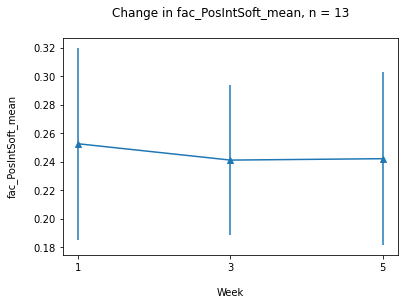

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.002338,2,0.001169,0.24153,0.787045,0.763943,0.01696,0.898254,True,0.886729,0.516239
1,Error,0.135533,28,0.004840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.239,0.225,0.014,0.077,two-sided,0.178,0.9,0.063
1,1,3,0.239,0.242,-0.003,0.080,two-sided,-0.041,0.9,-0.015
2,2,3,0.225,0.242,-0.017,0.080,two-sided,-0.213,0.9,-0.078


fac_SadIntHard_mean, n = 13


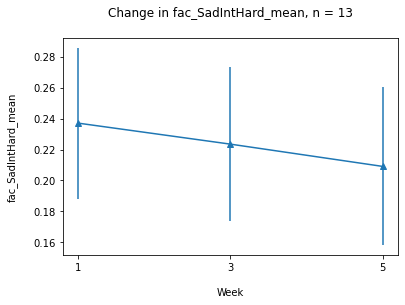

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.001258,2,0.000629,0.03652,0.964185,0.938515,0.002602,0.804514,True,0.757014,0.216307
1,Error,0.482339,28,0.017226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.215,0.222,-0.008,0.066,two-sided,-0.119,0.9,-0.042
1,1,3,0.215,0.209,0.005,0.068,two-sided,0.080,0.9,0.029
2,2,3,0.222,0.209,0.013,0.068,two-sided,0.195,0.9,0.072


fac_SadIntSoft_mean, n = 13


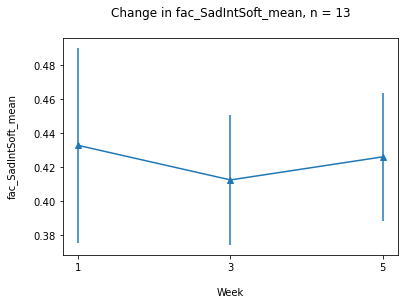

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.007669,2,0.003835,0.317539,0.730525,0.621455,0.022178,0.600851,False,0.335694,0.00247
1,Error,0.338121,28,0.012076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.435,0.458,-0.023,0.065,two-sided,-0.348,0.900,-0.123
1,1,3,0.435,0.426,0.009,0.068,two-sided,0.133,0.900,0.049
2,2,3,0.458,0.426,0.032,0.068,two-sided,0.468,0.878,0.172


fac_SadPres_mean, n = 13


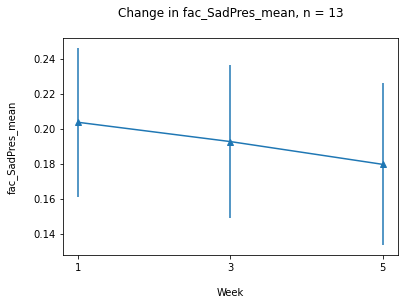

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.000372,2,0.000186,0.018715,0.981472,0.954699,0.001335,0.739683,True,0.64807,0.092028
1,Error,0.278168,28,0.009935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.187,0.185,0.002,0.057,two-sided,0.041,0.9,0.015
1,1,3,0.187,0.180,0.007,0.059,two-sided,0.121,0.9,0.045
2,2,3,0.185,0.180,0.005,0.059,two-sided,0.082,0.9,0.030


fac_SurIntHard_mean, n = 13


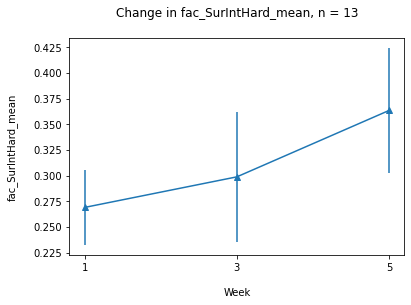

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.055628,2,0.027814,1.939384,0.162626,0.173346,0.121672,0.789667,True,0.733644,0.182041
1,Error,0.401569,28,0.014342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.275,0.306,-0.031,0.075,two-sided,-0.416,0.900,-0.148
1,1,3,0.275,0.363,-0.089,0.078,two-sided,-1.140,0.491,-0.419
2,2,3,0.306,0.363,-0.057,0.078,two-sided,-0.739,0.722,-0.272


fac_SurIntSoft_mean, n = 13


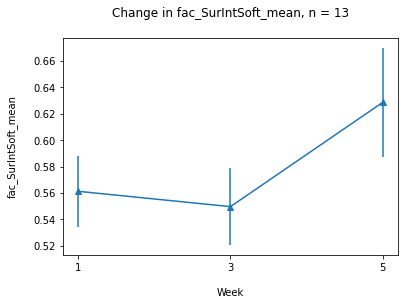

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.067165,2,0.033582,4.453518,0.020926,0.031332,0.241337,0.783742,True,0.72407,0.169353
1,Error,0.211138,28,0.007541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.569,0.531,0.038,0.047,two-sided,0.804,0.684,0.286
1,1,3,0.569,0.629,-0.060,0.049,two-sided,-1.226,0.440,-0.451
2,2,3,0.531,0.629,-0.098,0.049,two-sided,-2.001,0.115,-0.736


fac_SurPres_mean, n = 13


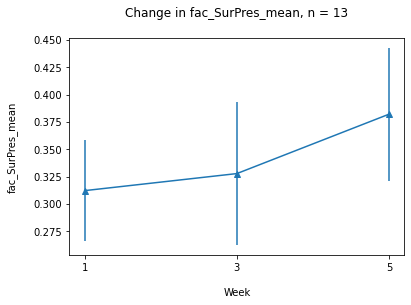

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.031148,2,0.015574,0.960897,0.394808,0.376084,0.064227,0.763493,True,0.69023,0.130157
1,Error,0.453819,28,0.016208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.317,0.335,-0.019,0.079,two-sided,-0.239,0.900,-0.085
1,1,3,0.317,0.382,-0.065,0.082,two-sided,-0.803,0.685,-0.295
2,2,3,0.335,0.382,-0.047,0.082,two-sided,-0.573,0.818,-0.211


mov_HeadVel_mean, n = 13


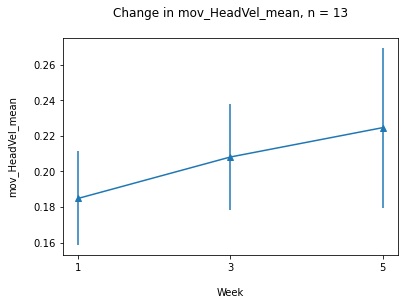

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.002674,2,0.001337,0.261673,0.771501,0.679634,0.017146,0.660096,False,0.485069,0.018703
1,Error,0.153257,30,0.005109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.209,0.206,0.003,0.048,two-sided,0.066,0.9,0.023
1,1,3,0.209,0.225,-0.015,0.049,two-sided,-0.310,0.9,-0.112
2,2,3,0.206,0.225,-0.018,0.050,two-sided,-0.368,0.9,-0.135


mov_HeadVel_std, n = 13


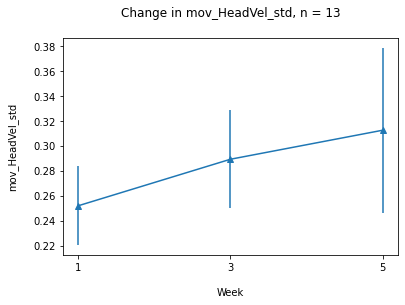

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.005354,2,0.002677,0.428231,0.655582,0.551329,0.027756,0.581713,False,0.28094,0.000928
1,Error,0.187553,30,0.006252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.285,0.297,-0.012,0.066,two-sided,-0.179,0.9,-0.063
1,1,3,0.285,0.313,-0.027,0.069,two-sided,-0.398,0.9,-0.144
2,2,3,0.297,0.313,-0.015,0.070,two-sided,-0.222,0.9,-0.082


mov_HposeDist_mean, n = 13


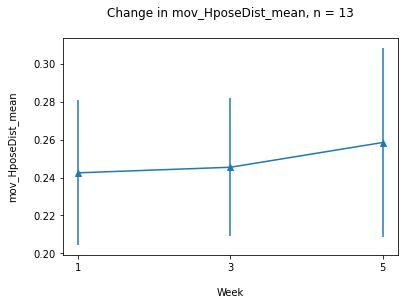

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.002379,2,0.001190,0.227948,0.797532,0.716876,0.014969,0.695326,False,0.561827,0.041958
1,Error,0.156554,30,0.005218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.258,0.243,0.015,0.056,two-sided,0.275,0.9,0.096
1,1,3,0.258,0.258,-0.000,0.058,two-sided,-0.006,0.9,-0.002
2,2,3,0.243,0.258,-0.016,0.059,two-sided,-0.266,0.9,-0.098


mov_HposeDist_std, n = 13


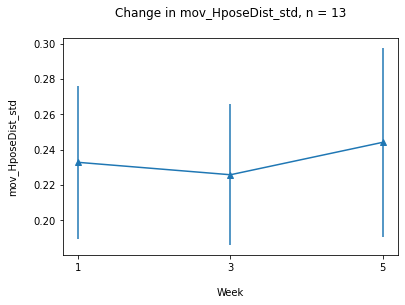

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.003806,2,0.001903,0.333388,0.719113,0.626428,0.021743,0.645659,False,0.451195,0.01256
1,Error,0.171260,30,0.005709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.252,0.230,0.022,0.062,two-sided,0.353,0.9,0.124
1,1,3,0.252,0.244,0.008,0.065,two-sided,0.120,0.9,0.044
2,2,3,0.230,0.244,-0.014,0.066,two-sided,-0.217,0.9,-0.080


mov_HposePitch_mean, n = 13


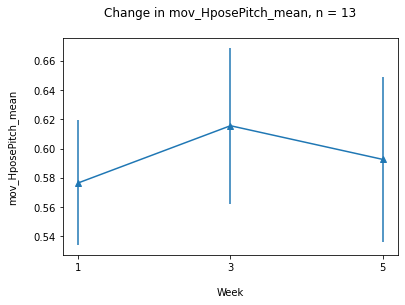

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.025256,2,0.012628,10.25762,0.000403,0.001903,0.40612,0.709863,True,0.591277,0.055571
1,Error,0.036932,30,0.001231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.550,0.604,-0.054,0.064,two-sided,-0.846,0.660,-0.296
1,1,3,0.550,0.593,-0.043,0.066,two-sided,-0.646,0.775,-0.234
2,2,3,0.604,0.593,0.011,0.067,two-sided,0.166,0.900,0.061


mov_HposePitch_std, n = 13


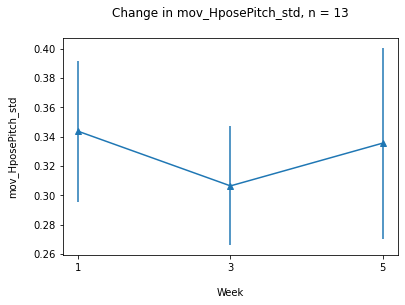

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.023529,2,0.011765,1.734233,0.193768,0.203394,0.103634,0.729283,True,0.628789,0.077943
1,Error,0.203513,30,0.006784,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.372,0.318,0.054,0.071,two-sided,0.761,0.709,0.266
1,1,3,0.372,0.336,0.037,0.074,two-sided,0.497,0.861,0.181
2,2,3,0.318,0.336,-0.017,0.075,two-sided,-0.232,0.900,-0.085


mov_HposeRoll_mean, n = 13


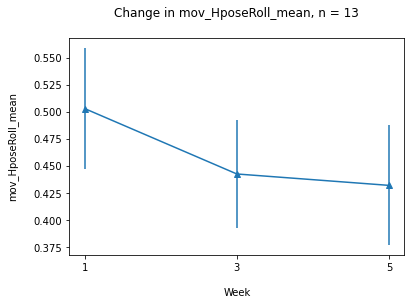

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.020694,2,0.010347,1.67019,0.205239,0.212066,0.10019,0.780192,True,0.718264,0.162017
1,Error,0.185855,30,0.006195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.478,0.434,0.044,0.071,two-sided,0.624,0.788,0.218
1,1,3,0.478,0.432,0.046,0.073,two-sided,0.628,0.786,0.228
2,2,3,0.434,0.432,0.002,0.075,two-sided,0.027,0.900,0.010


mov_HposeRoll_std, n = 13


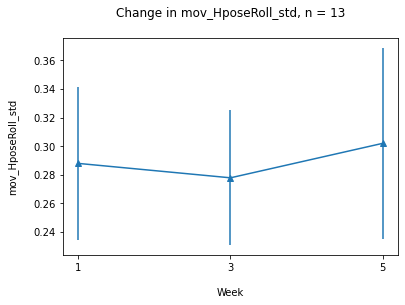

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.000491,2,0.000245,0.016832,0.983318,0.951406,0.001121,0.698949,False,0.569281,0.045113
1,Error,0.437197,30,0.014573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.308,0.300,0.008,0.074,two-sided,0.104,0.9,0.036
1,1,3,0.308,0.302,0.006,0.077,two-sided,0.072,0.9,0.026
2,2,3,0.300,0.302,-0.002,0.078,two-sided,-0.028,0.9,-0.010


mov_HposeYaw_mean, n = 13


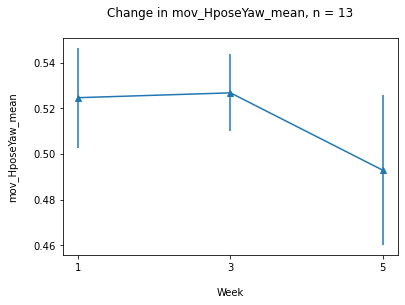

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.008916,2,0.004458,0.958362,0.394952,0.376148,0.060054,0.765224,True,0.693193,0.13326
1,Error,0.139549,30,0.004652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.513,0.529,-0.016,0.031,two-sided,-0.520,0.848,-0.182
1,1,3,0.513,0.493,0.020,0.032,two-sided,0.619,0.791,0.225
2,2,3,0.529,0.493,0.036,0.032,two-sided,1.103,0.512,0.406


mov_HposeYaw_std, n = 13


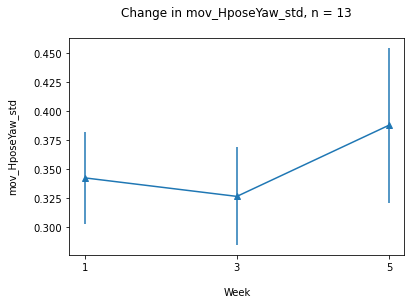

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.015692,2,0.007846,1.459709,0.248334,0.250045,0.088684,0.704609,True,0.580773,0.050354
1,Error,0.161256,30,0.005375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.374,0.342,0.031,0.071,two-sided,0.441,0.893,0.154
1,1,3,0.374,0.388,-0.014,0.074,two-sided,-0.196,0.900,-0.071
2,2,3,0.342,0.388,-0.046,0.075,two-sided,-0.612,0.795,-0.225


nlp_sentiment_mean_mean, n = 12


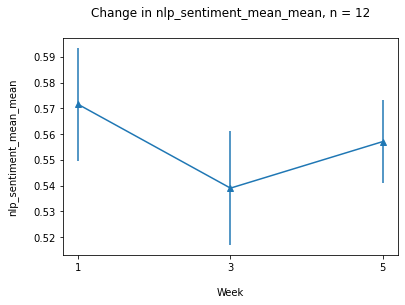

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.016532,2,0.008266,3.026711,0.06456,0.081799,0.177763,0.75498,True,0.675461,0.140605
1,Error,0.076468,28,0.002731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.575,0.527,0.047,0.026,two-sided,1.828,0.163,0.660
1,1,3,0.575,0.557,0.017,0.027,two-sided,0.643,0.777,0.242
2,2,3,0.527,0.557,-0.030,0.027,two-sided,-1.093,0.518,-0.416


nlp_sentiment_range_mean, n = 12


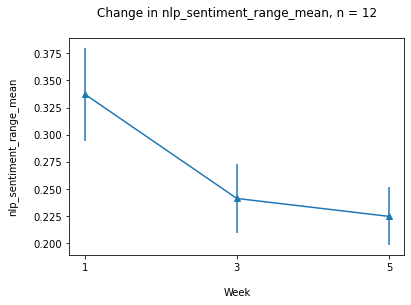

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.208191,2,0.104095,-3.491477,1.0,1.0,-0.332252,0.872254,True,0.853545,0.453037
1,Error,-0.834796,28,-0.029814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.387,0.256,0.131,0.058,two-sided,2.272,0.062,0.821
1,1,3,0.387,0.225,0.163,0.060,two-sided,2.704,0.020,1.016
2,2,3,0.256,0.225,0.032,0.061,two-sided,0.516,0.851,0.197


nlp_sentiment_stdev_mean, n = 12


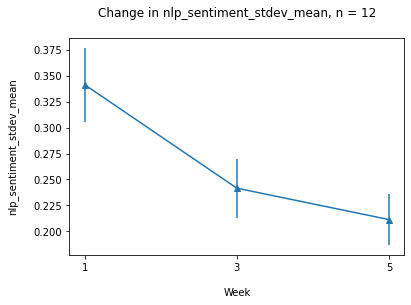

,Source,SS,DF,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,timepoint,0.264085,2,0.132042,-4.021563,1.0,1.0,-0.403025,0.818996,True,0.778993,0.286858
1,Error,-0.919340,28,-0.032834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,0.397,0.254,0.143,0.053,two-sided,2.684,0.021,0.970
1,1,3,0.397,0.211,0.186,0.056,two-sided,3.339,0.003,1.254
2,2,3,0.254,0.211,0.042,0.057,two-sided,0.752,0.715,0.286


In [29]:
sig = pd.DataFrame([], columns = ['biomarker', 'change'])
sig_dbms = []
for dbm in dbms:
    aov, pt = rm_anova(dbm, dft1, dft2, dft3, resp)
    
    if isinstance(pt, pd.DataFrame):
        #setting threshold for ANOVA
        if aov.loc[0,'p-unc']<=0.1:
            sig_dbms.append(dbm)
        
        #setting threshold for pairwise
        if pt.loc[1, 'p-tukey'] <=0.1:
            
            if pt.loc[1,'diff'] < 0:
                diff = 'increasing'
            else:
                diff = 'decreasing'
            temp = pd.DataFrame([[dbm, diff]], columns = ['biomarker', 'change'])
            sig = sig.append(temp).reset_index(drop=True)
            
    plot(dbm, dft1, dft2, dft3, resp)
    display(aov)
    display(pt)

In [30]:
sig

,biomarker,change
0,aco_voicePct_mean_negimg,increasing
1,fac_AngIntSoft_mean_negimg,increasing
2,fac_AngIntSoft_mean_neuimg,increasing
3,fac_AngIntSoft_mean_posimg,increasing
4,fac_ComIntSoft_mean_negimg,increasing
5,fac_ComIntSoft_mean_neuimg,increasing
6,fac_ComIntSoft_mean_posimg,increasing
7,fac_ConIntSoft_mean_negimg,increasing
8,fac_ConIntSoft_mean_neuimg,increasing
9,fac_ConIntSoft_mean_posimg,increasing


In [31]:
sig_dbms

['aco_voicePct_mean_negimg',
 'aco_voicePct_mean_neuimg',
 'aco_voicePct_mean_posimg',
 'fac_AngIntSoft_mean_negimg',
 'fac_AngIntSoft_mean_neuimg',
 'fac_AngIntSoft_mean_posimg',
 'fac_AngPres_mean_neuimg',
 'fac_ComIntHard_mean_negimg',
 'fac_ComIntHard_mean_neuimg',
 'fac_ComIntHard_mean_posimg',
 'fac_ComIntSoft_mean_negimg',
 'fac_ComIntSoft_mean_neuimg',
 'fac_ComIntSoft_mean_posimg',
 'fac_ConIntHard_mean_negimg',
 'fac_ConIntHard_mean_posimg',
 'fac_ConIntSoft_mean_negimg',
 'fac_ConIntSoft_mean_neuimg',
 'fac_ConIntSoft_mean_posimg',
 'fac_DisIntHard_mean_neuimg',
 'fac_DisIntSoft_mean_negimg',
 'fac_DisIntSoft_mean_neuimg',
 'fac_DisIntSoft_mean_posimg',
 'fac_FeaIntHard_mean_neuimg',
 'fac_FeaIntSoft_mean_negimg',
 'fac_FeaIntSoft_mean_neuimg',
 'fac_FeaIntSoft_mean_posimg',
 'fac_FeaPres_mean_neuimg',
 'fac_HapIntSoft_mean_negimg',
 'fac_HapIntSoft_mean_neuimg',
 'fac_HapIntSoft_mean_posimg',
 'fac_NegIntHard_mean_negimg',
 'fac_NegIntHard_mean_posimg',
 'fac_NegIntSoft_mea